# Osobny autoenkoder dla każdego kanału na dataecie SMAP

### Wczytanie danych

In [1]:
import pandas as pd
import numpy as np

# Wczytanie metadanych
metadata = pd.read_csv("labeled_anomalies.csv")
smap_channels = metadata[metadata['spacecraft'] == 'SMAP']['chan_id'].tolist()

smap_train_data = {}
for channel in smap_channels:
    try:
        data = np.load(f"data/train/{channel}.npy")
        smap_train_data[channel] = data
    except FileNotFoundError:
        print(f"{channel}: brak danych")
    
smap_test_data = {}
for channel in smap_channels:
    try:
        data = np.load(f"data/test/{channel}.npy")
        smap_test_data[channel] = data   
    except FileNotFoundError:
        print(f"{channel}: brak danych")

del data
del channel

### Funkcja tworzenia okien czasowych

In [2]:
def create_windows(data, window_size, step_size):
    windows = []
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end])
    return np.array(windows)


### Tworzenie okien czasowych dla pojedynczego kanału

In [3]:
from sklearn.preprocessing import MinMaxScaler

window_size = 10 
window_step = 1

# Wybór czujnika
sensor_name = smap_channels[0]
print(f"Wybrano czujnik: {sensor_name}")

train_data = smap_train_data[sensor_name]
# Normalizacja danych do przedziału [0, 1]
scaler = MinMaxScaler()
arr_norm = scaler.fit_transform(train_data)

# Tworzenie okien czasowych dla danych treningowych
arr_norm_windows = create_windows(arr_norm, window_size, window_step)

arr_norm_windows = arr_norm_windows.reshape(arr_norm_windows.shape[0], -1)
input_dim = arr_norm_windows.shape[1]  


del arr_norm, train_data


Wybrano czujnik: P-1


### Definicja modelu

In [4]:
import torch
from torch import nn, optim

if torch.cuda.is_available():
    print("GPU is available :)")
    device = torch.device("cuda")
else:
    print("GPU is NOT available, using CPU. :(")
    device = torch.device("cpu")

class AE(nn.Module):
    def __init__(self, input_dim):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),

        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

GPU is available :)


## Nauka na danych treningowych

In [5]:
from torch.utils.data import DataLoader, TensorDataset

epochs = 10
batch_size = 64

X_train = torch.tensor(arr_norm_windows, dtype=torch.float32).to(device)
train_dataset = TensorDataset(X_train)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

model = AE(input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        x_batch = batch[0]
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, x_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.6f}")


Epoch 10/10, Loss: 0.020344


# Autoencoder na danych testowych

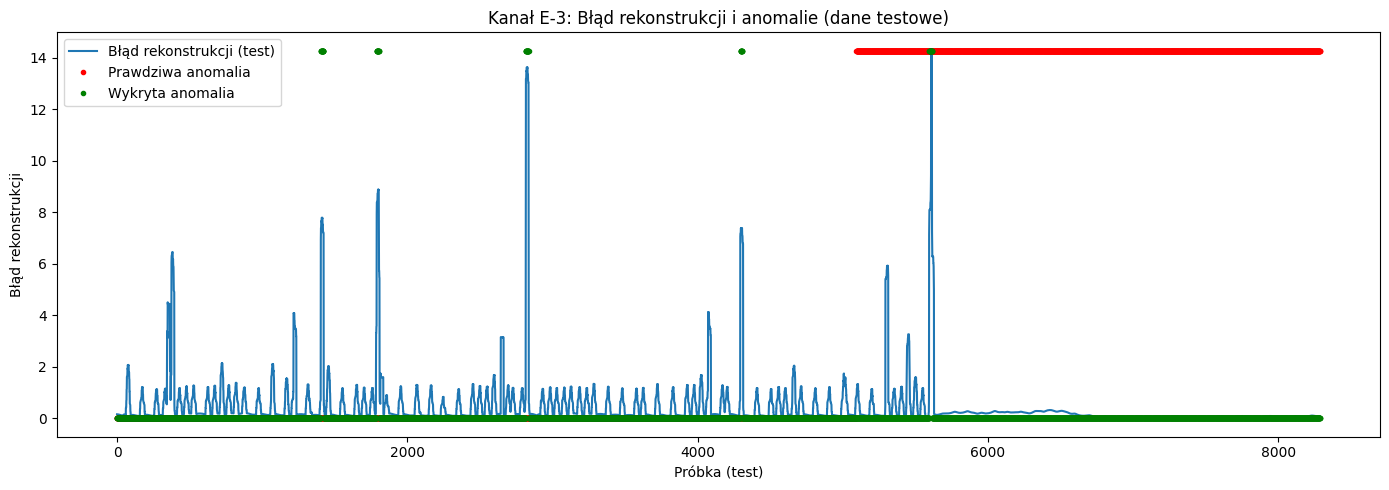

Confusion matrix (test):
[[5031   63]
 [3174   20]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.61      0.99      0.76      5094
     Anomaly       0.24      0.01      0.01      3194

    accuracy                           0.61      8288
   macro avg       0.43      0.50      0.38      8288
weighted avg       0.47      0.61      0.47      8288

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5094, 8306]: WYKRYTA


In [ ]:
# Normalizacja oraz wczytanie danych testowych 
sensor_test_data = smap_test_data[sensor_name]
arr_test_norm = scaler.transform(sensor_test_data)
def create_windows(data, window_size):
    return np.array([data[i:i+window_size].flatten() for i in range(len(data) - window_size + 1)])
arr_test_norm_windows = create_windows(arr_test_norm, window_size)
X_test = torch.tensor(arr_test_norm_windows, dtype=torch.float32).to(device)

# Rekonstrukcja i obliczenie błędu rekonstrukcji na danych testowych
model.eval()
with torch.no_grad():
    recon = model(X_test).cpu().numpy()
recon_error = np.mean((arr_test_norm_windows - recon) ** 2, axis=1)   

# Wykrywanie anomalii na danych testowych
threshold = np.percentile(recon_error, 99)
predicted_anomaly = (recon_error > threshold).astype(int)

# Prawdziwe anomalie z labeled_anomalies.csv dla testowych indeksów
anomaly_row = metadata[metadata['chan_id'] == sensor_name]
anomaly_sequences = []
if not anomaly_row.empty:
    anomaly_sequences = (anomaly_row.iloc[0]['anomaly_sequences'])

true_anomaly = np.zeros(len(recon_error), dtype=int)   
for seq in anomaly_sequences:
    start, end = seq
    true_anomaly[start:min(end+1, len(true_anomaly))] = 1

# Wizualizacja wyników na danych testowych
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

plt.figure(figsize=(14, 5))
plt.plot(recon_error, label="Błąd rekonstrukcji (test)")
plt.plot(true_anomaly * np.max(recon_error), 'r.', label="Prawdziwa anomalia")
plt.plot(predicted_anomaly * np.max(recon_error), 'g.', label="Wykryta anomalia")
plt.title(f"Kanał {sensor_name}: Błąd rekonstrukcji i anomalie (dane testowe)")
plt.xlabel("Próbka (test)")
plt.ylabel("Błąd rekonstrukcji")
plt.legend()
plt.tight_layout()
plt.show()

print("Confusion matrix (test):")
print(confusion_matrix(true_anomaly, predicted_anomaly))
print("\nClassification report (test):")
print(classification_report(true_anomaly, predicted_anomaly, target_names=["Normal", "Anomaly"]))

# Sprawdzenie czy wykryto PRZYNAJMNIEJ JEDNĄ próbkę z każdej zdefiniowanej anomalii
detected_ranges = [] 
remaining_sequences = anomaly_sequences.copy()

for seq in anomaly_sequences:
    start, end = seq
    if np.any(predicted_anomaly[start:min(end+1, len(predicted_anomaly))] == 1):
        detected_ranges.append(seq)

# Wypisanie wyników
print("Wynik sprawdzania anomalii względem metadanych:")
for seq in anomaly_sequences:
    if seq in detected_ranges:
        print(f"Anomalia {seq}: WYKRYTA")
    else:
        print(f"Anomalia {seq}: NIEWYKRYTA")


# Dla wszystkich kanałów SMAP


Czujnik: P-1
Epoch 12/100, Loss: 0.041955
Epoch 24/100, Loss: 0.040938
Epoch 36/100, Loss: 0.028793
Epoch 48/100, Loss: 0.026400
Epoch 60/100, Loss: 0.021458
Epoch 72/100, Loss: 0.015722
Epoch 84/100, Loss: 0.011891
Epoch 96/100, Loss: 0.010210
Epoch 100/100, Loss: 0.009840
Threshold (percentyl 95) na danych testowych: 0.020492


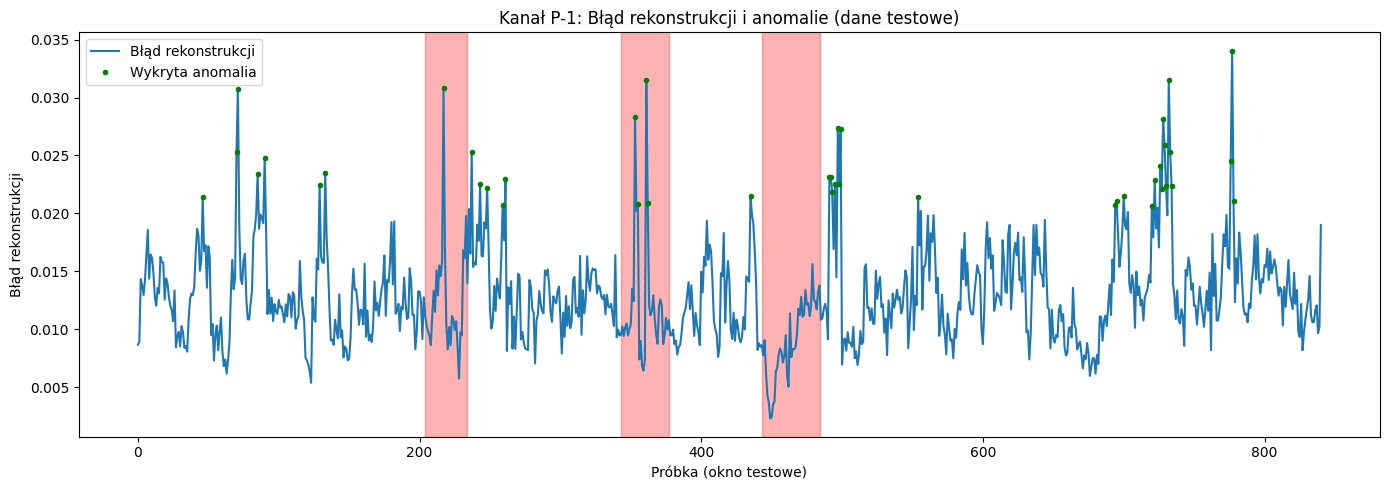

Confusion matrix (test):
[[699  37]
 [100   5]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.87      0.95      0.91       736
     Anomaly       0.12      0.05      0.07       105

    accuracy                           0.84       841
   macro avg       0.50      0.50      0.49       841
weighted avg       0.78      0.84      0.81       841

Wynik sprawdzania anomalii względem metadanych:
Anomalia [2149, 2349]: WYKRYTA
Anomalia [4536, 4844]: NIEWYKRYTA
Anomalia [3539, 3779]: WYKRYTA

Czujnik: S-1
Epoch 12/100, Loss: 0.103370
Epoch 24/100, Loss: 0.103836
Epoch 36/100, Loss: 0.103075
Epoch 48/100, Loss: 0.099106
Epoch 60/100, Loss: 0.089125
Epoch 72/100, Loss: 0.075190
Epoch 84/100, Loss: 0.065325
Epoch 96/100, Loss: 0.053542
Epoch 100/100, Loss: 0.050610
Threshold (percentyl 95) na danych testowych: 0.127919


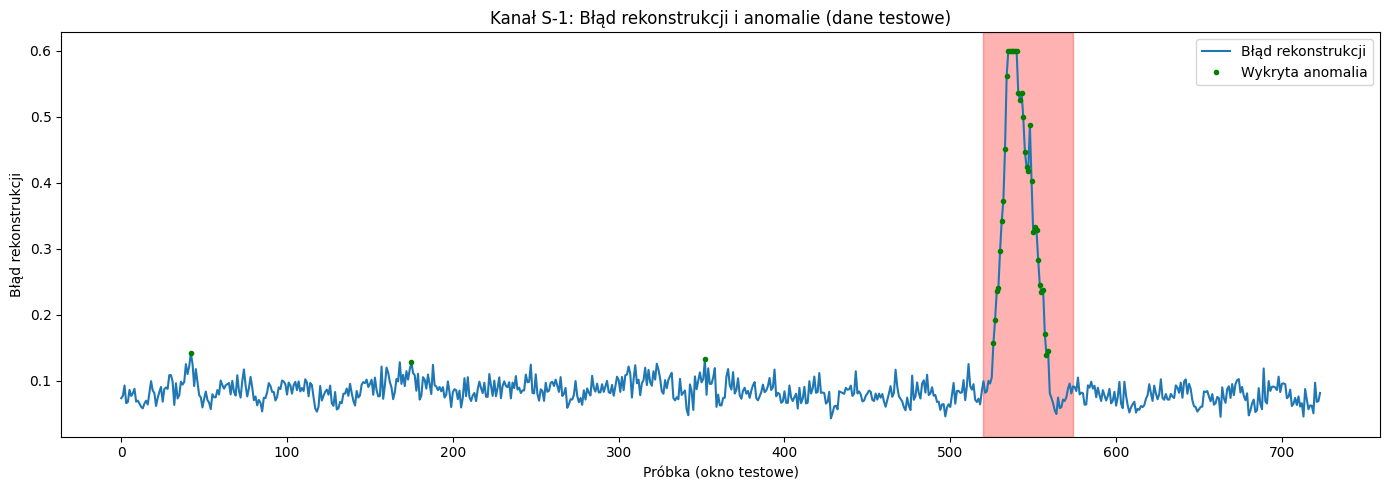

Confusion matrix (test):
[[667   3]
 [ 20  34]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98       670
     Anomaly       0.92      0.63      0.75        54

    accuracy                           0.97       724
   macro avg       0.94      0.81      0.87       724
weighted avg       0.97      0.97      0.97       724

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5300, 5747]: WYKRYTA

Czujnik: E-1
Epoch 12/100, Loss: 0.125293
Epoch 24/100, Loss: 0.036662
Epoch 36/100, Loss: 0.021545
Epoch 48/100, Loss: 0.014745
Epoch 60/100, Loss: 0.012168
Epoch 72/100, Loss: 0.011051
Epoch 84/100, Loss: 0.009780
Epoch 96/100, Loss: 0.009028
Epoch 100/100, Loss: 0.009305
Threshold (percentyl 95) na danych testowych: 0.141393


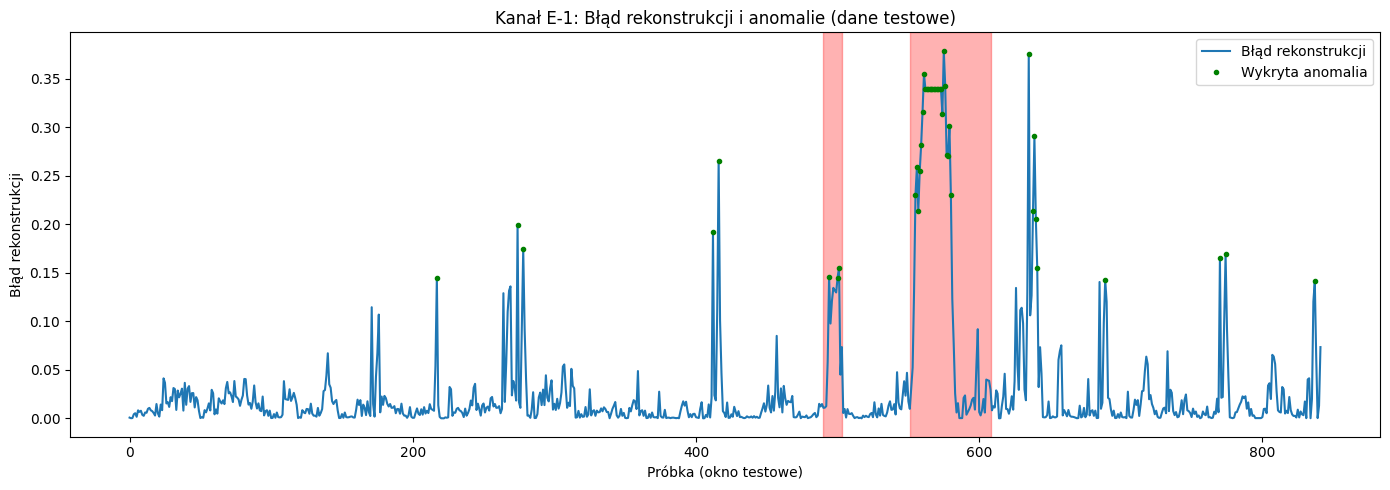

Confusion matrix (test):
[[759  14]
 [ 40  29]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.95      0.98      0.97       773
     Anomaly       0.67      0.42      0.52        69

    accuracy                           0.94       842
   macro avg       0.81      0.70      0.74       842
weighted avg       0.93      0.94      0.93       842

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5000, 5030]: WYKRYTA
Anomalia [5610, 6086]: WYKRYTA

Czujnik: E-2
Epoch 12/100, Loss: 0.062631
Epoch 24/100, Loss: 0.016186
Epoch 36/100, Loss: 0.007287
Epoch 48/100, Loss: 0.005067
Epoch 60/100, Loss: 0.004231
Epoch 72/100, Loss: 0.003671
Epoch 84/100, Loss: 0.003279
Epoch 96/100, Loss: 0.002816
Epoch 100/100, Loss: 0.002776
Threshold (percentyl 95) na danych testowych: 0.023804


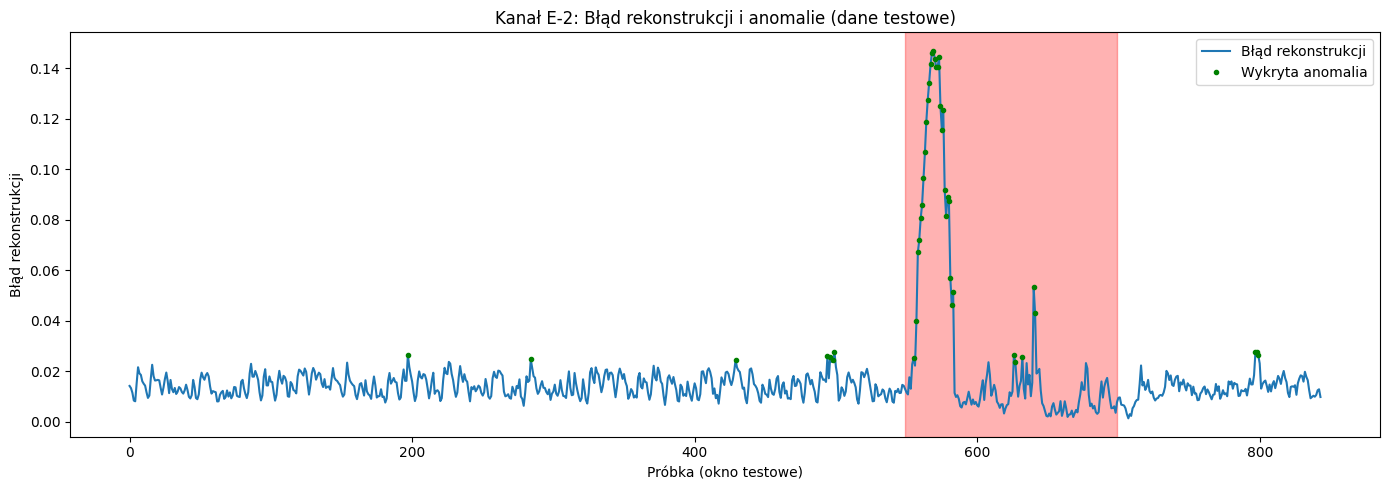

Confusion matrix (test):
[[684  10]
 [117  33]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.85      0.99      0.92       694
     Anomaly       0.77      0.22      0.34       150

    accuracy                           0.85       844
   macro avg       0.81      0.60      0.63       844
weighted avg       0.84      0.85      0.81       844

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5598, 6995]: WYKRYTA

Czujnik: E-3
Epoch 12/100, Loss: 0.016563
Epoch 24/100, Loss: 0.007954
Epoch 36/100, Loss: 0.002875
Epoch 48/100, Loss: 0.002530
Epoch 60/100, Loss: 0.002395
Epoch 72/100, Loss: 0.002186
Epoch 84/100, Loss: 0.002110
Epoch 96/100, Loss: 0.001956
Epoch 100/100, Loss: 0.001960
Threshold (percentyl 95) na danych testowych: 0.009049


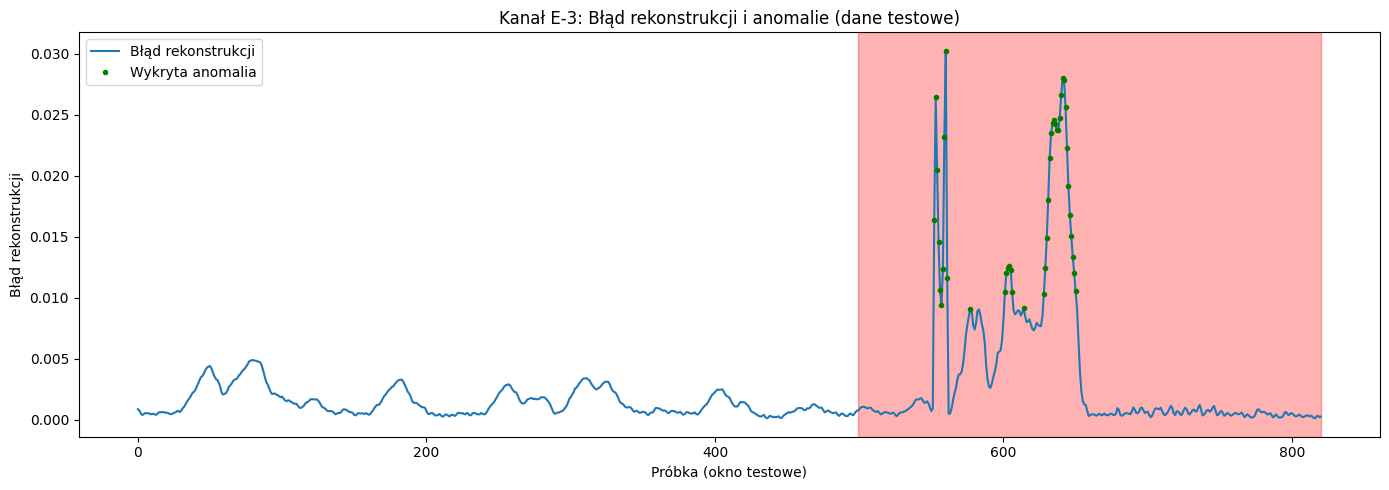

Confusion matrix (test):
[[500   0]
 [280  41]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.64      1.00      0.78       500
     Anomaly       1.00      0.13      0.23       321

    accuracy                           0.66       821
   macro avg       0.82      0.56      0.50       821
weighted avg       0.78      0.66      0.56       821

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5094, 8306]: WYKRYTA

Czujnik: E-4
Epoch 12/100, Loss: 0.042319
Epoch 24/100, Loss: 0.025877
Epoch 36/100, Loss: 0.012536
Epoch 48/100, Loss: 0.007182
Epoch 60/100, Loss: 0.005081
Epoch 72/100, Loss: 0.004208
Epoch 84/100, Loss: 0.003404
Epoch 96/100, Loss: 0.002848
Epoch 100/100, Loss: 0.002540
Threshold (percentyl 95) na danych testowych: 0.011223


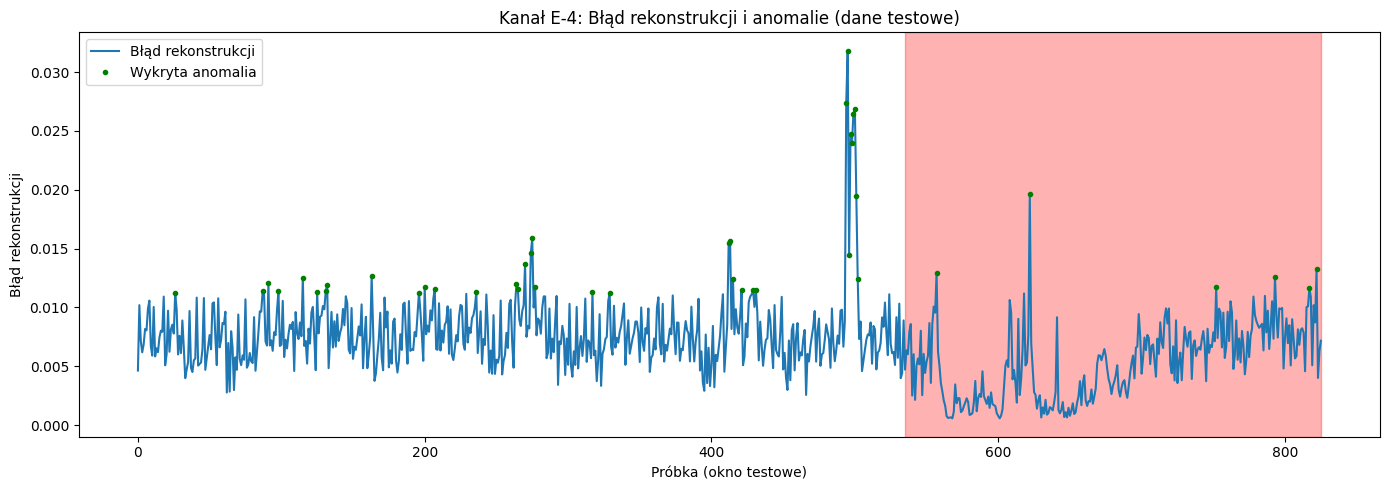

Confusion matrix (test):
[[500  36]
 [284   6]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.64      0.93      0.76       536
     Anomaly       0.14      0.02      0.04       290

    accuracy                           0.61       826
   macro avg       0.39      0.48      0.40       826
weighted avg       0.46      0.61      0.50       826

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5450, 8261]: WYKRYTA

Czujnik: E-5
Epoch 12/100, Loss: 0.144124
Epoch 24/100, Loss: 0.045653
Epoch 36/100, Loss: 0.025342
Epoch 48/100, Loss: 0.013710
Epoch 60/100, Loss: 0.010220
Epoch 72/100, Loss: 0.006933
Epoch 84/100, Loss: 0.006060
Epoch 96/100, Loss: 0.006296
Epoch 100/100, Loss: 0.005833
Threshold (percentyl 95) na danych testowych: 0.068182


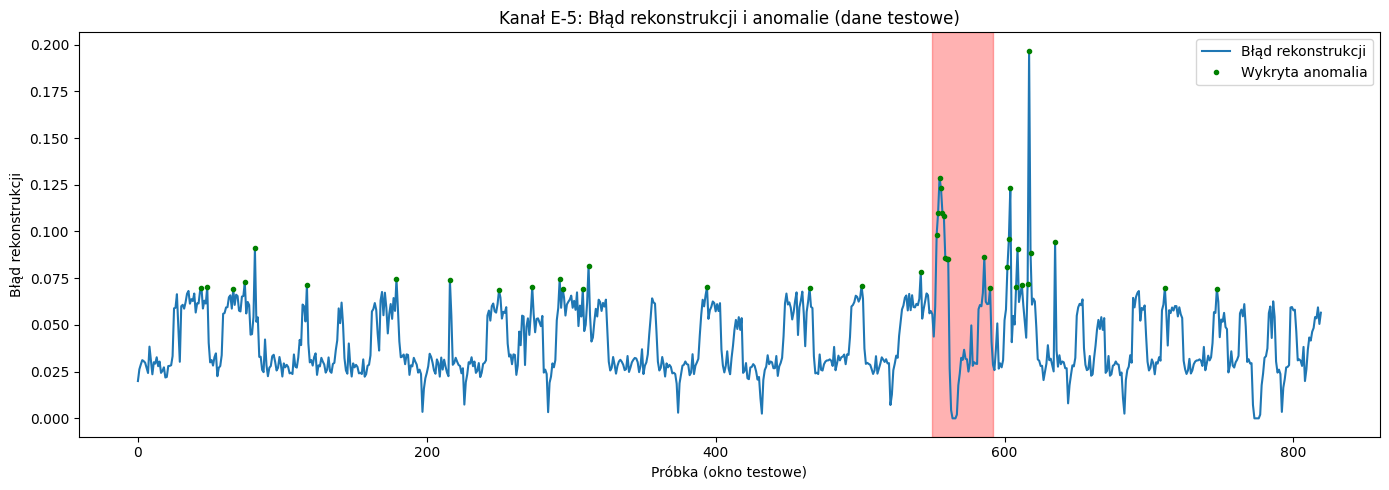

Confusion matrix (test):
[[749  30]
 [ 30  11]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96       779
     Anomaly       0.27      0.27      0.27        41

    accuracy                           0.93       820
   macro avg       0.61      0.61      0.61       820
weighted avg       0.93      0.93      0.93       820

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5600, 5920]: WYKRYTA

Czujnik: E-6
Epoch 12/100, Loss: 0.126472
Epoch 24/100, Loss: 0.127088
Epoch 36/100, Loss: 0.110542
Epoch 48/100, Loss: 0.066204
Epoch 60/100, Loss: 0.027721
Epoch 72/100, Loss: 0.017503
Epoch 84/100, Loss: 0.014432
Epoch 96/100, Loss: 0.011310
Epoch 100/100, Loss: 0.011236
Threshold (percentyl 95) na danych testowych: 0.192441


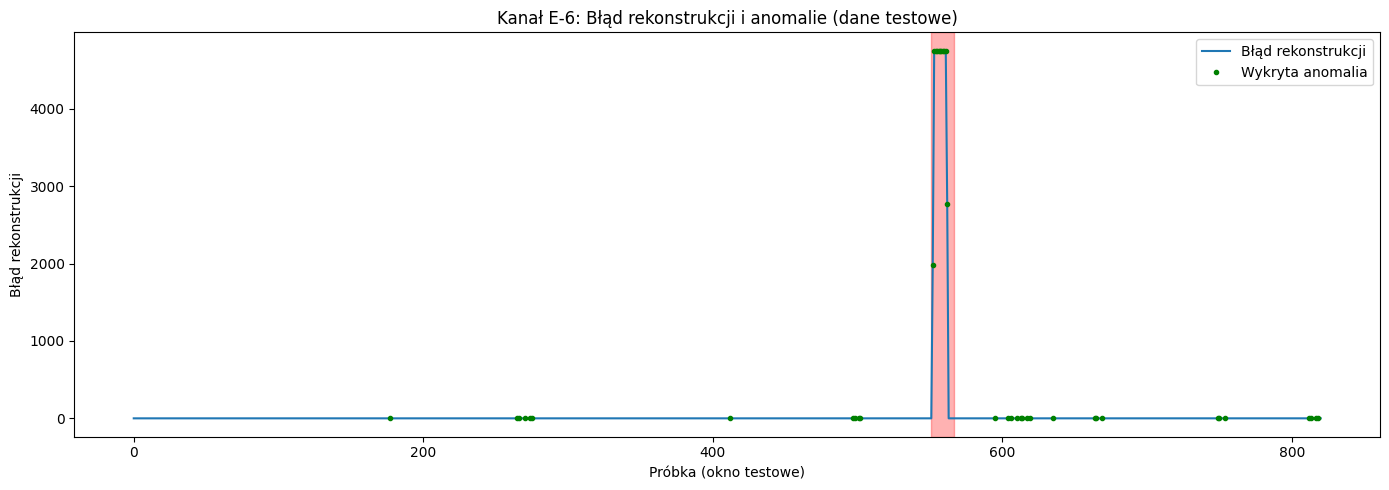

Confusion matrix (test):
[[775  30]
 [  5  11]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.99      0.96      0.98       805
     Anomaly       0.27      0.69      0.39        16

    accuracy                           0.96       821
   macro avg       0.63      0.83      0.68       821
weighted avg       0.98      0.96      0.97       821

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5610, 5675]: WYKRYTA

Czujnik: E-7
Epoch 12/100, Loss: 0.065153
Epoch 24/100, Loss: 0.061980
Epoch 36/100, Loss: 0.061714
Epoch 48/100, Loss: 0.051941
Epoch 60/100, Loss: 0.039261
Epoch 72/100, Loss: 0.033329
Epoch 84/100, Loss: 0.029272
Epoch 96/100, Loss: 0.027572
Epoch 100/100, Loss: 0.027053
Threshold (percentyl 95) na danych testowych: 0.059411


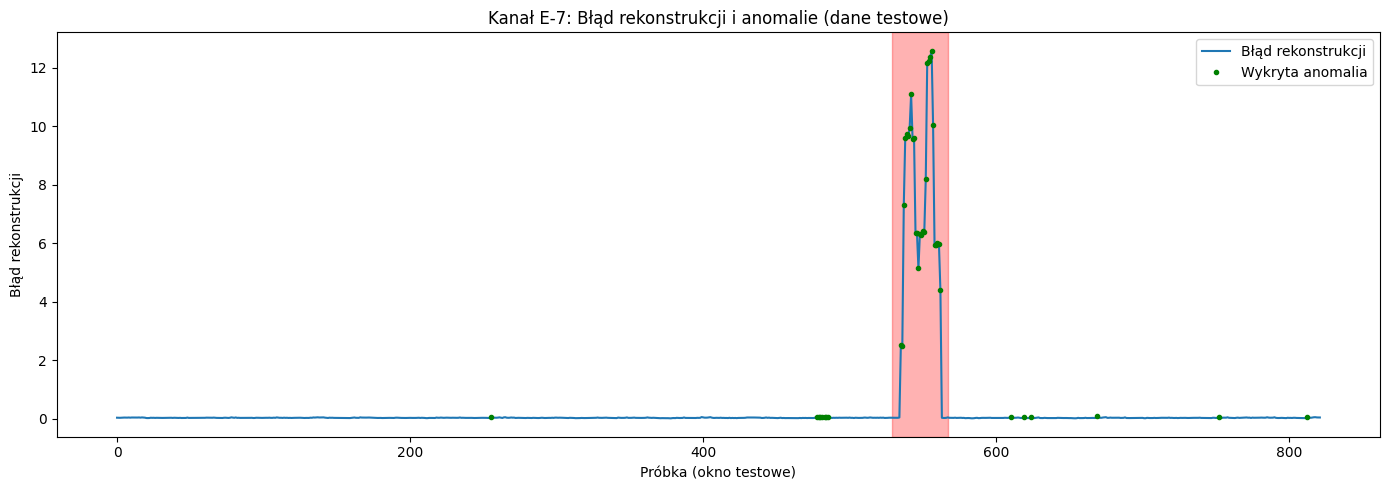

Confusion matrix (test):
[[770  14]
 [ 10  28]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.98       784
     Anomaly       0.67      0.74      0.70        38

    accuracy                           0.97       822
   macro avg       0.83      0.86      0.84       822
weighted avg       0.97      0.97      0.97       822

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5394, 5674]: WYKRYTA

Czujnik: E-8
Epoch 12/100, Loss: 0.027716
Epoch 24/100, Loss: 0.006835
Epoch 36/100, Loss: 0.003558
Epoch 48/100, Loss: 0.002587
Epoch 60/100, Loss: 0.002044
Epoch 72/100, Loss: 0.002008
Epoch 84/100, Loss: 0.001529
Epoch 96/100, Loss: 0.001385
Epoch 100/100, Loss: 0.001358
Threshold (percentyl 95) na danych testowych: 0.021288


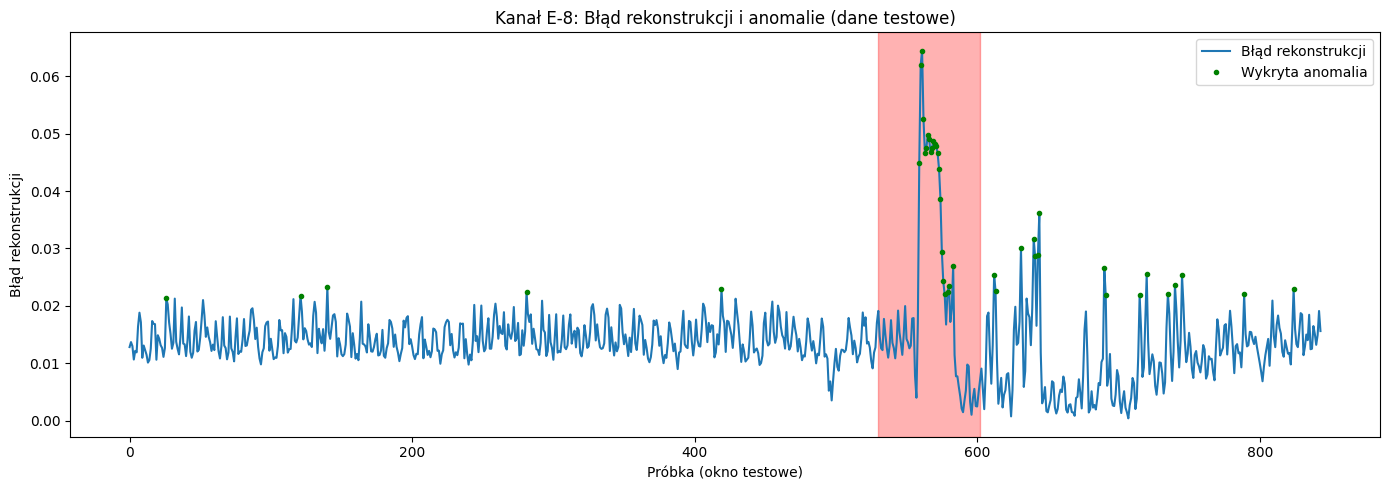

Confusion matrix (test):
[[751  21]
 [ 50  22]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.94      0.97      0.95       772
     Anomaly       0.51      0.31      0.38        72

    accuracy                           0.92       844
   macro avg       0.72      0.64      0.67       844
weighted avg       0.90      0.92      0.91       844

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5400, 6022]: WYKRYTA

Czujnik: E-9
Epoch 12/100, Loss: 0.017166
Epoch 24/100, Loss: 0.008360
Epoch 36/100, Loss: 0.004253
Epoch 48/100, Loss: 0.003806
Epoch 60/100, Loss: 0.002649
Epoch 72/100, Loss: 0.002222
Epoch 84/100, Loss: 0.001999
Epoch 96/100, Loss: 0.001986
Epoch 100/100, Loss: 0.001826
Threshold (percentyl 95) na danych testowych: 0.008761


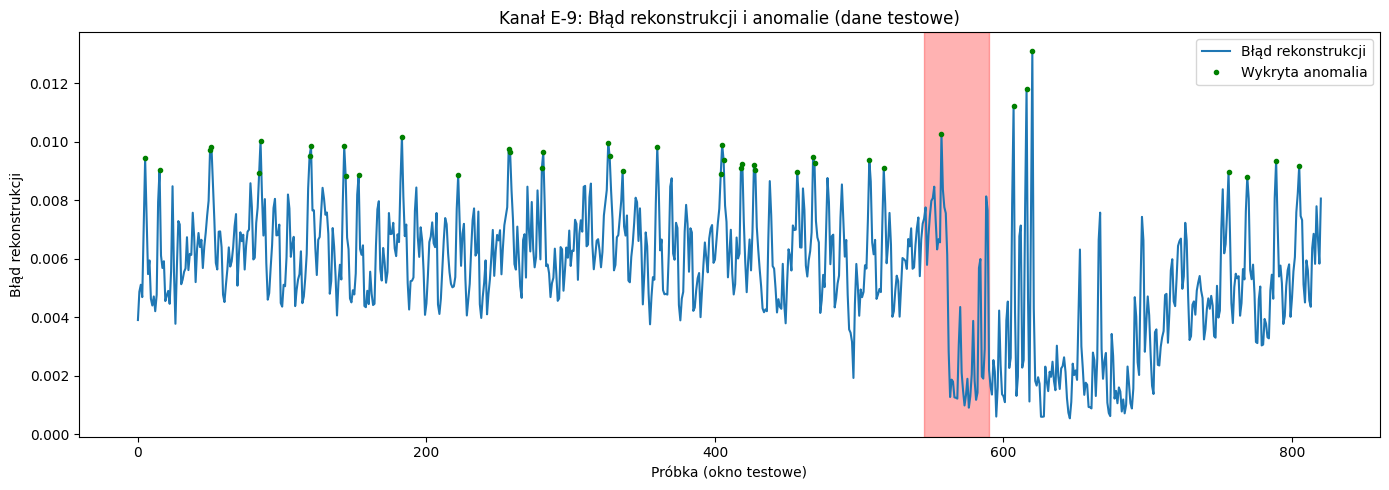

Confusion matrix (test):
[[737  40]
 [ 43   1]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.94      0.95      0.95       777
     Anomaly       0.02      0.02      0.02        44

    accuracy                           0.90       821
   macro avg       0.48      0.49      0.49       821
weighted avg       0.90      0.90      0.90       821

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5550, 5900]: WYKRYTA

Czujnik: E-10
Epoch 12/100, Loss: 0.114429
Epoch 24/100, Loss: 0.044123
Epoch 36/100, Loss: 0.029439
Epoch 48/100, Loss: 0.016537
Epoch 60/100, Loss: 0.012844
Epoch 72/100, Loss: 0.009074
Epoch 84/100, Loss: 0.007948
Epoch 96/100, Loss: 0.007409
Epoch 100/100, Loss: 0.007887
Threshold (percentyl 95) na danych testowych: 0.150191


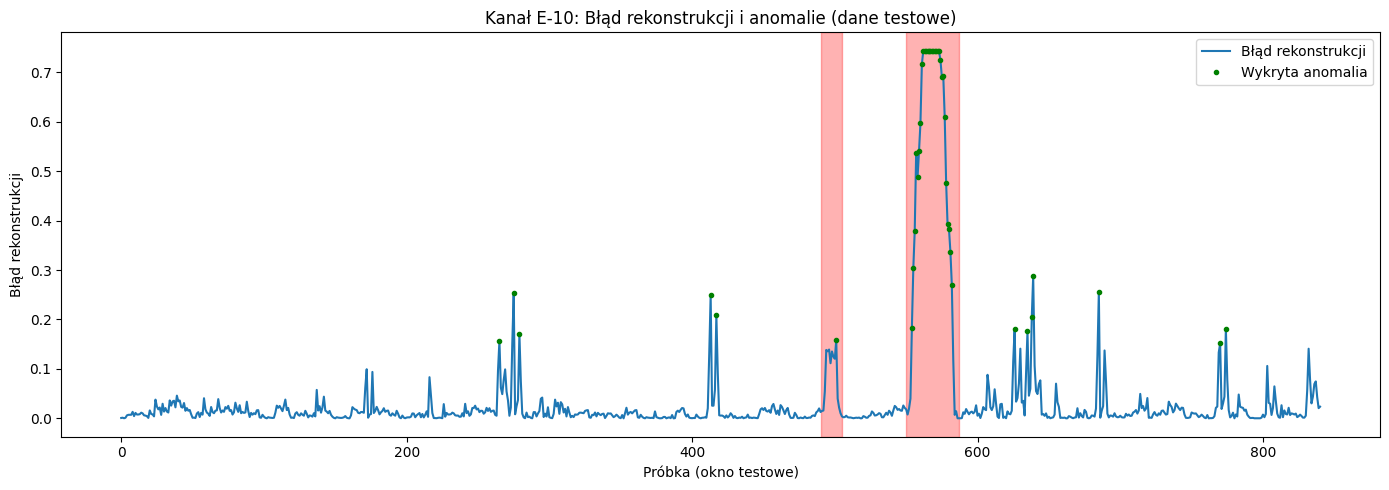

Confusion matrix (test):
[[778  12]
 [ 21  30]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.97      0.98      0.98       790
     Anomaly       0.71      0.59      0.65        51

    accuracy                           0.96       841
   macro avg       0.84      0.79      0.81       841
weighted avg       0.96      0.96      0.96       841

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5000, 5050]: WYKRYTA
Anomalia [5601, 5871]: WYKRYTA

Czujnik: E-11
Epoch 12/100, Loss: 0.133685
Epoch 24/100, Loss: 0.046098
Epoch 36/100, Loss: 0.022395
Epoch 48/100, Loss: 0.019282
Epoch 60/100, Loss: 0.013202
Epoch 72/100, Loss: 0.012622
Epoch 84/100, Loss: 0.009881
Epoch 96/100, Loss: 0.009949
Epoch 100/100, Loss: 0.010104
Threshold (percentyl 95) na danych testowych: 0.172861


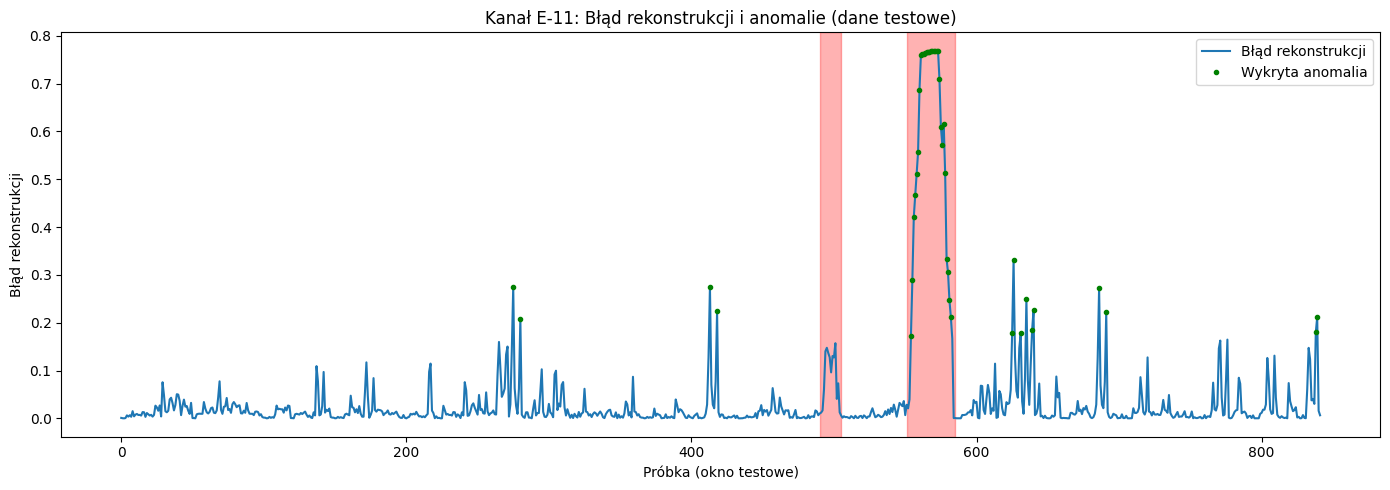

Confusion matrix (test):
[[780  14]
 [ 19  29]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98       794
     Anomaly       0.67      0.60      0.64        48

    accuracy                           0.96       842
   macro avg       0.83      0.79      0.81       842
weighted avg       0.96      0.96      0.96       842

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5000, 5050]: NIEWYKRYTA
Anomalia [5614, 5857]: WYKRYTA

Czujnik: E-12
Epoch 12/100, Loss: 0.144093
Epoch 24/100, Loss: 0.051900
Epoch 36/100, Loss: 0.026994
Epoch 48/100, Loss: 0.016998
Epoch 60/100, Loss: 0.013900
Epoch 72/100, Loss: 0.011629
Epoch 84/100, Loss: 0.010556
Epoch 96/100, Loss: 0.008166
Epoch 100/100, Loss: 0.007757
Threshold (percentyl 95) na danych testowych: 0.113333


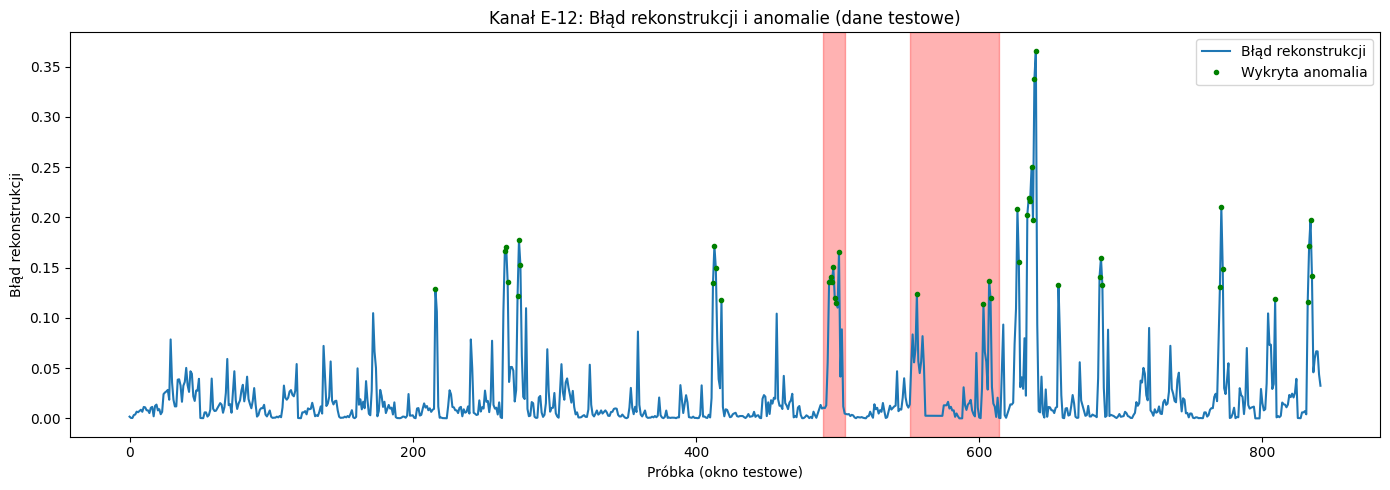

Confusion matrix (test):
[[733  32]
 [ 66  11]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.92      0.96      0.94       765
     Anomaly       0.26      0.14      0.18        77

    accuracy                           0.88       842
   macro avg       0.59      0.55      0.56       842
weighted avg       0.86      0.88      0.87       842

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5610, 6141]: WYKRYTA
Anomalia [5000, 5050]: WYKRYTA

Czujnik: E-13
Epoch 12/100, Loss: 0.075405
Epoch 24/100, Loss: 0.060346
Epoch 36/100, Loss: 0.025920
Epoch 48/100, Loss: 0.016023
Epoch 60/100, Loss: 0.011441
Epoch 72/100, Loss: 0.009555
Epoch 84/100, Loss: 0.008663
Epoch 96/100, Loss: 0.007906
Epoch 100/100, Loss: 0.007558
Threshold (percentyl 95) na danych testowych: 0.038464


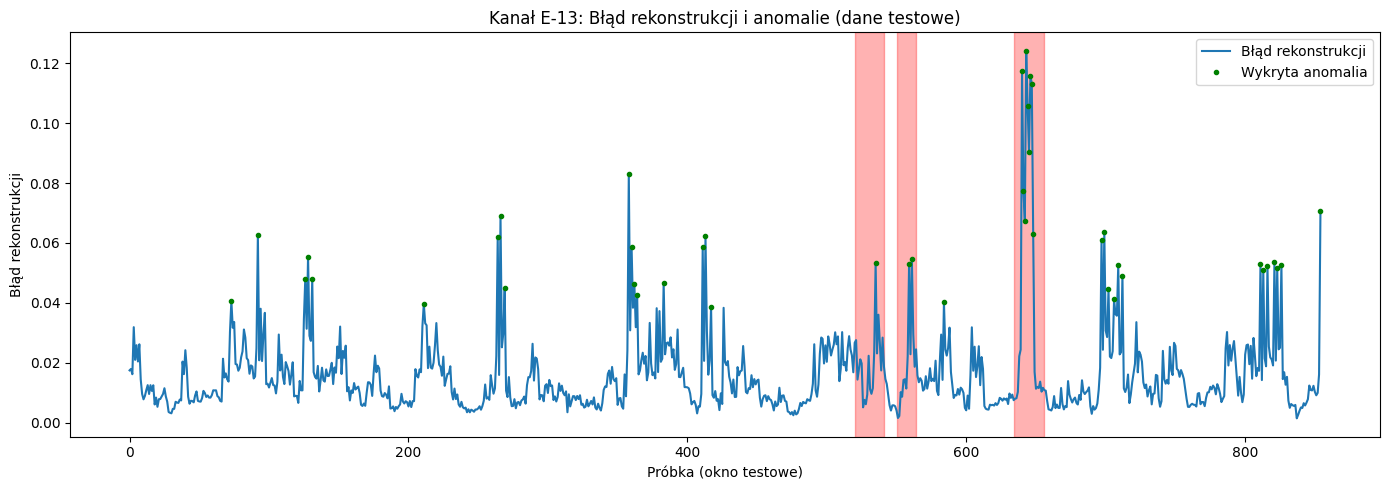

Confusion matrix (test):
[[769  31]
 [ 43  12]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.95      0.96      0.95       800
     Anomaly       0.28      0.22      0.24        55

    accuracy                           0.91       855
   macro avg       0.61      0.59      0.60       855
weighted avg       0.90      0.91      0.91       855

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5309, 5410]: WYKRYTA
Anomalia [5600, 5640]: WYKRYTA
Anomalia [6449, 6569]: WYKRYTA

Czujnik: A-1
Epoch 12/100, Loss: 0.000000
Epoch 24/100, Loss: 0.000000
Epoch 36/100, Loss: 0.000000
Epoch 48/100, Loss: 0.000000
Epoch 60/100, Loss: 0.000000
Epoch 72/100, Loss: 0.000000
Epoch 84/100, Loss: 0.000000
Epoch 96/100, Loss: 0.000000
Epoch 100/100, Loss: 0.000000
Threshold (percentyl 95) na danych testowych: 0.000001


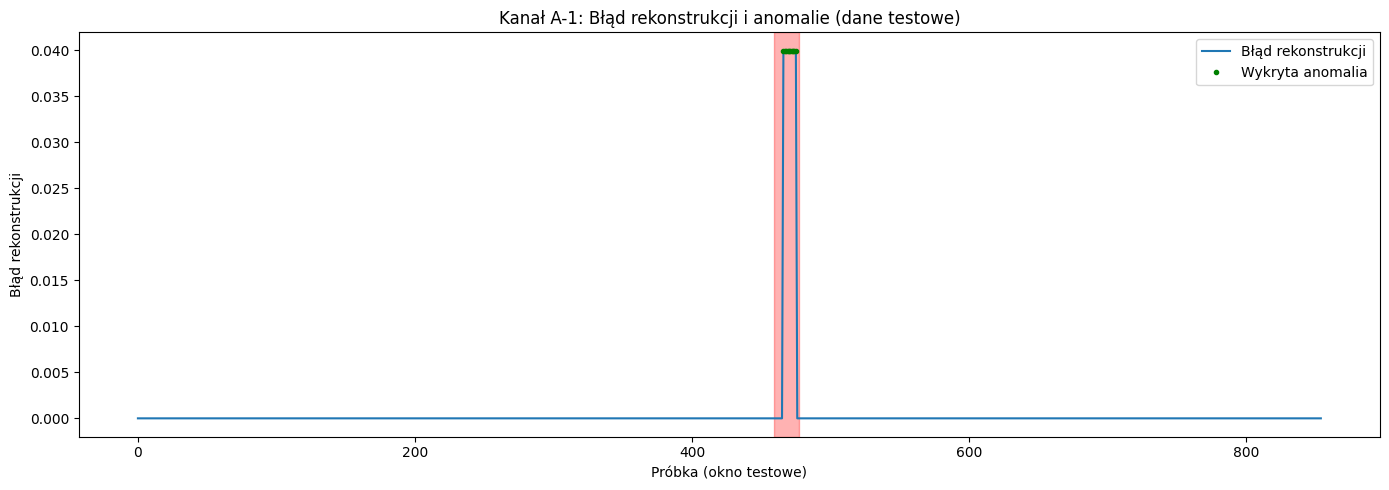

Confusion matrix (test):
[[837   0]
 [  8  10]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00       837
     Anomaly       1.00      0.56      0.71        18

    accuracy                           0.99       855
   macro avg       1.00      0.78      0.85       855
weighted avg       0.99      0.99      0.99       855

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4690, 4774]: WYKRYTA

Czujnik: D-1
Epoch 12/100, Loss: 0.016894
Epoch 24/100, Loss: 0.011628
Epoch 36/100, Loss: 0.010711
Epoch 48/100, Loss: 0.009286
Epoch 60/100, Loss: 0.007876
Epoch 72/100, Loss: 0.006991
Epoch 84/100, Loss: 0.006696
Epoch 96/100, Loss: 0.006088
Epoch 100/100, Loss: 0.005840
Threshold (percentyl 95) na danych testowych: 7.322873


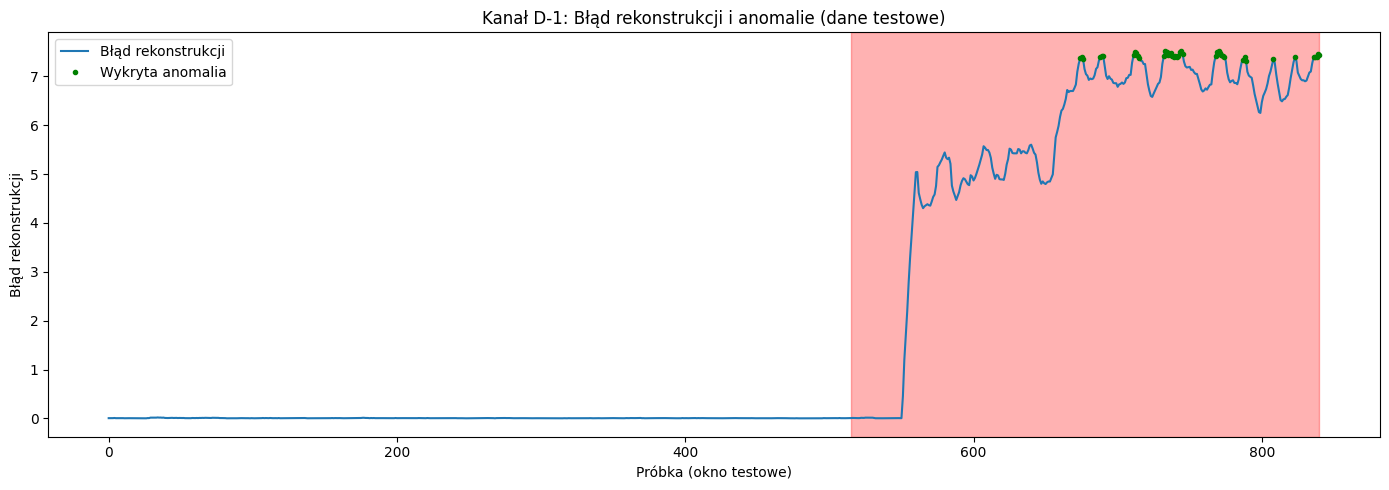

Confusion matrix (test):
[[516   0]
 [283  42]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.65      1.00      0.78       516
     Anomaly       1.00      0.13      0.23       325

    accuracy                           0.66       841
   macro avg       0.82      0.56      0.51       841
weighted avg       0.78      0.66      0.57       841

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5250, 8508]: WYKRYTA

Czujnik: P-3
Epoch 12/100, Loss: 0.005302
Epoch 24/100, Loss: 0.001937
Epoch 36/100, Loss: 0.001595
Epoch 48/100, Loss: 0.001589
Epoch 60/100, Loss: 0.001528
Epoch 72/100, Loss: 0.001499
Epoch 84/100, Loss: 0.001506
Epoch 96/100, Loss: 0.001469
Epoch 100/100, Loss: 0.001460
Threshold (percentyl 95) na danych testowych: 0.055640


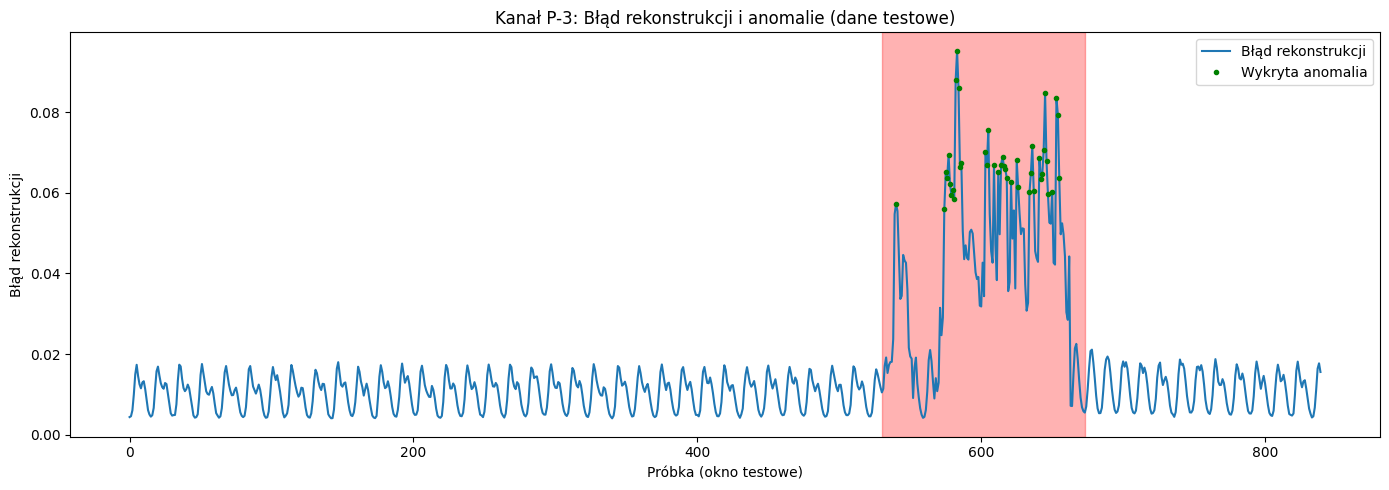

Confusion matrix (test):
[[697   0]
 [101  42]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.87      1.00      0.93       697
     Anomaly       1.00      0.29      0.45       143

    accuracy                           0.88       840
   macro avg       0.94      0.65      0.69       840
weighted avg       0.89      0.88      0.85       840

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5401, 6736]: WYKRYTA

Czujnik: D-2
Epoch 12/100, Loss: 0.000000
Epoch 24/100, Loss: 0.000000
Epoch 36/100, Loss: 0.000000
Epoch 48/100, Loss: 0.000000
Epoch 60/100, Loss: 0.000000
Epoch 72/100, Loss: 0.000000
Epoch 84/100, Loss: 0.000000
Epoch 96/100, Loss: 0.000000
Epoch 100/100, Loss: 0.000000
Threshold (percentyl 95) na danych testowych: 4.000000


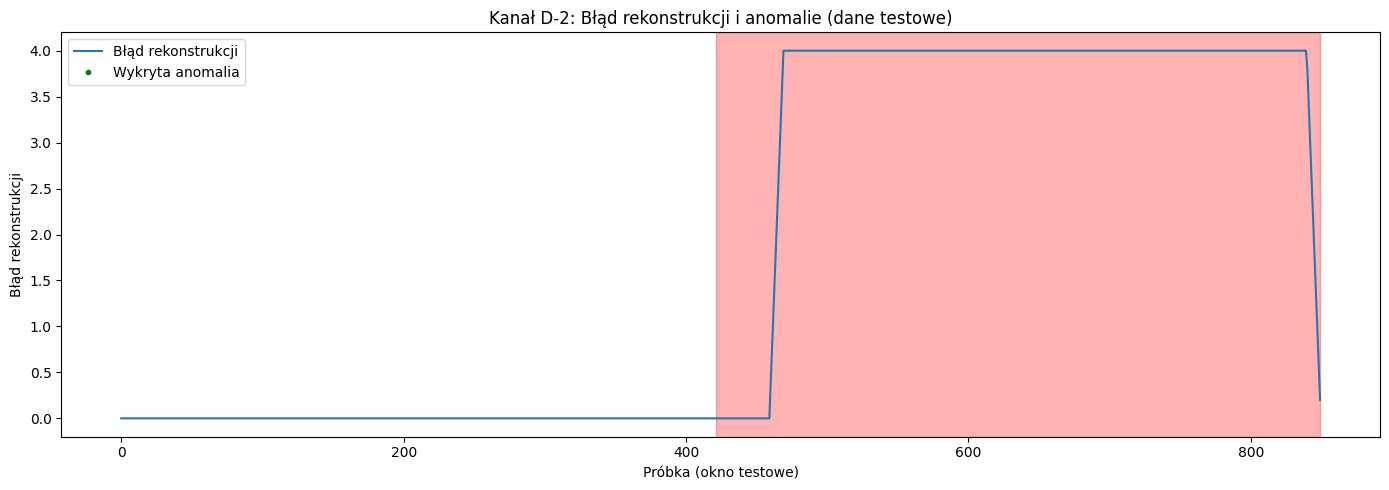

Confusion matrix (test):
[[422   0]
 [428   0]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.50      1.00      0.66       422
     Anomaly       0.00      0.00      0.00       428

    accuracy                           0.50       850
   macro avg       0.25      0.50      0.33       850
weighted avg       0.25      0.50      0.33       850

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4319, 8536]: NIEWYKRYTA

Czujnik: D-3


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 12/100, Loss: 0.001254
Epoch 24/100, Loss: 0.000797
Epoch 36/100, Loss: 0.000520
Epoch 48/100, Loss: 0.000509
Epoch 60/100, Loss: 0.000286
Epoch 72/100, Loss: 0.000181
Epoch 84/100, Loss: 0.000204
Epoch 96/100, Loss: 0.000116
Epoch 100/100, Loss: 0.000112
Threshold (percentyl 95) na danych testowych: 3241.599935


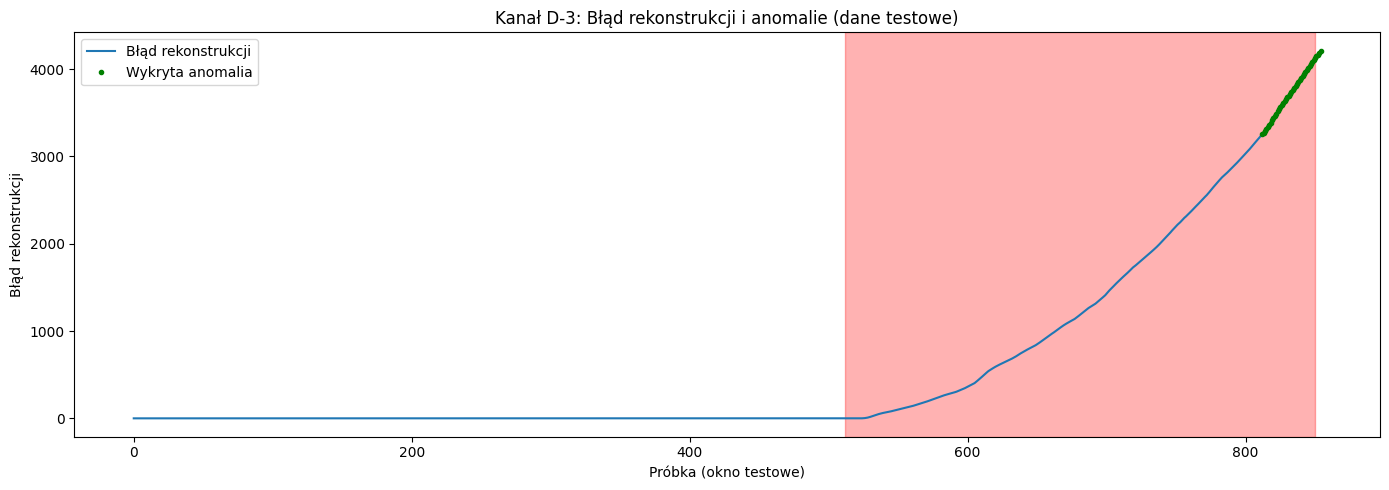

Confusion matrix (test):
[[513   5]
 [299  38]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.63      0.99      0.77       518
     Anomaly       0.88      0.11      0.20       337

    accuracy                           0.64       855
   macro avg       0.76      0.55      0.49       855
weighted avg       0.73      0.64      0.55       855

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5225, 8500]: WYKRYTA

Czujnik: D-4
Epoch 12/100, Loss: 0.003077
Epoch 24/100, Loss: 0.001127
Epoch 36/100, Loss: 0.001199
Epoch 48/100, Loss: 0.001119
Epoch 60/100, Loss: 0.001160
Epoch 72/100, Loss: 0.000974
Epoch 84/100, Loss: 0.000969
Epoch 96/100, Loss: 0.000904
Epoch 100/100, Loss: 0.000925
Threshold (percentyl 95) na danych testowych: 3234.160633


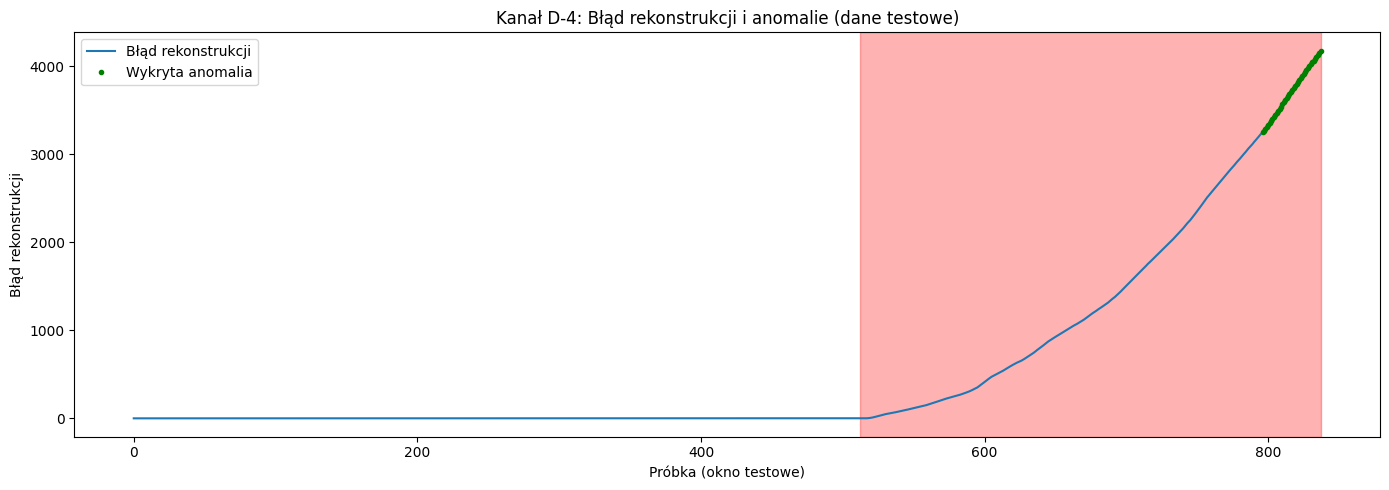

Confusion matrix (test):
[[513   0]
 [283  42]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.64      1.00      0.78       513
     Anomaly       1.00      0.13      0.23       325

    accuracy                           0.66       838
   macro avg       0.82      0.56      0.51       838
weighted avg       0.78      0.66      0.57       838

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5225, 8472]: WYKRYTA

Czujnik: A-2
Epoch 12/100, Loss: 0.011775
Epoch 24/100, Loss: 0.007484
Epoch 36/100, Loss: 0.006713
Epoch 48/100, Loss: 0.006457
Epoch 60/100, Loss: 0.006157
Epoch 72/100, Loss: 0.005948
Epoch 84/100, Loss: 0.005886
Epoch 96/100, Loss: 0.005763
Epoch 100/100, Loss: 0.005754
Threshold (percentyl 95) na danych testowych: 0.016499


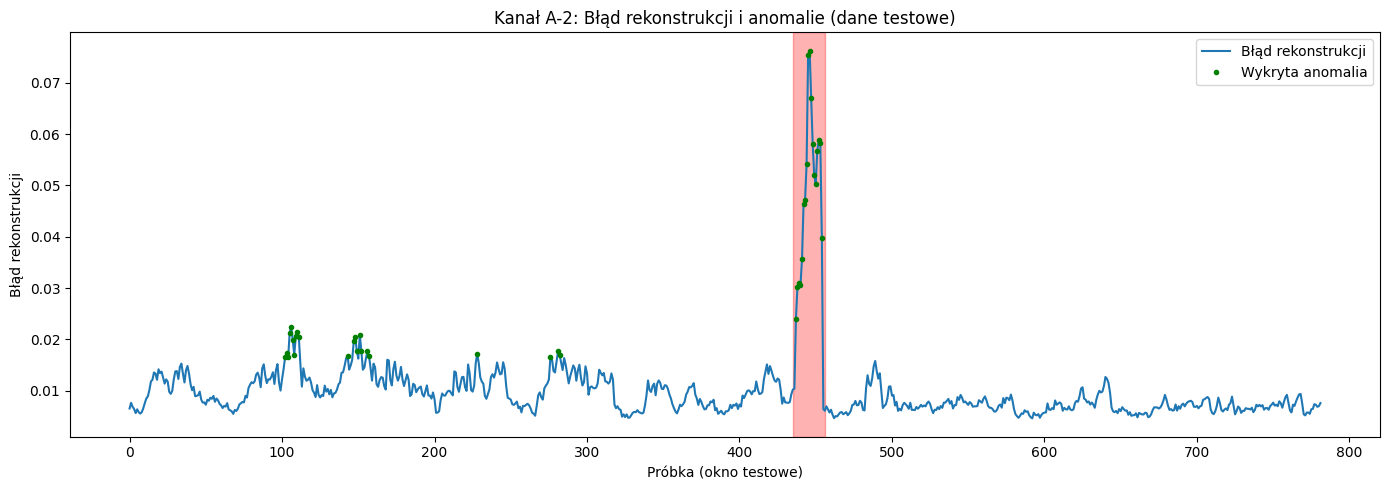

Confusion matrix (test):
[[740  22]
 [  2  18]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.98       762
     Anomaly       0.45      0.90      0.60        20

    accuracy                           0.97       782
   macro avg       0.72      0.94      0.79       782
weighted avg       0.98      0.97      0.97       782

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4450, 4560]: WYKRYTA

Czujnik: A-3
Epoch 12/100, Loss: 0.007587
Epoch 24/100, Loss: 0.006292
Epoch 36/100, Loss: 0.005676
Epoch 48/100, Loss: 0.005429
Epoch 60/100, Loss: 0.005273
Epoch 72/100, Loss: 0.004660
Epoch 84/100, Loss: 0.004101
Epoch 96/100, Loss: 0.003965
Epoch 100/100, Loss: 0.004419
Threshold (percentyl 95) na danych testowych: 0.007170


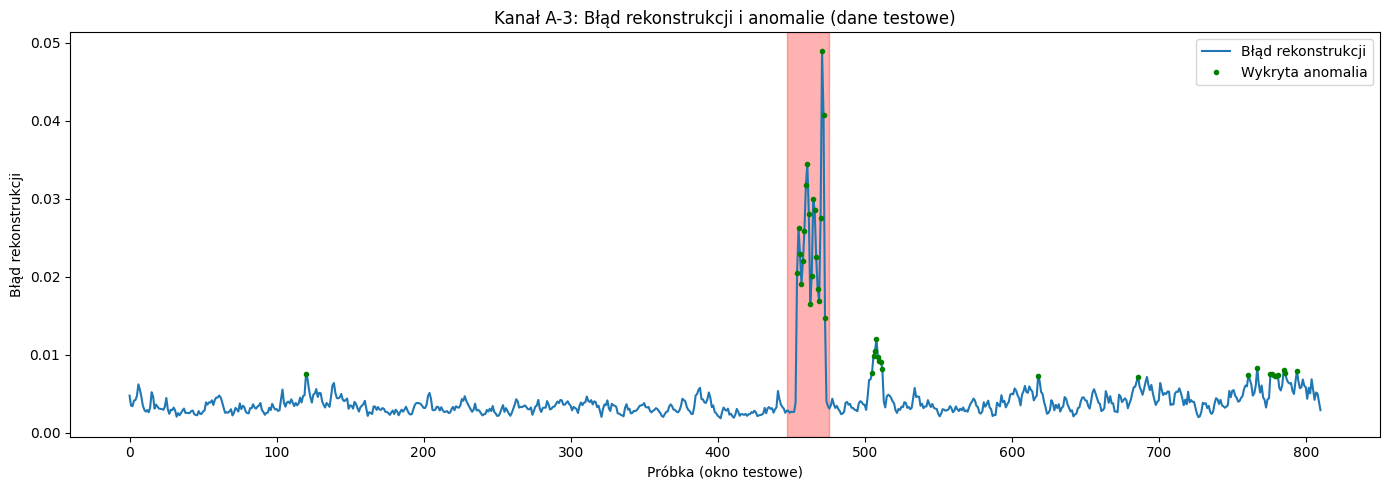

Confusion matrix (test):
[[762  21]
 [  8  20]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98       783
     Anomaly       0.49      0.71      0.58        28

    accuracy                           0.96       811
   macro avg       0.74      0.84      0.78       811
weighted avg       0.97      0.96      0.97       811

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4575, 4760]: WYKRYTA

Czujnik: A-4
Epoch 12/100, Loss: 0.006071
Epoch 24/100, Loss: 0.006415
Epoch 36/100, Loss: 0.005684
Epoch 48/100, Loss: 0.005548
Epoch 60/100, Loss: 0.005473
Epoch 72/100, Loss: 0.005647
Epoch 84/100, Loss: 0.005538
Epoch 96/100, Loss: 0.005602
Epoch 100/100, Loss: 0.005609
Threshold (percentyl 95) na danych testowych: 0.014359


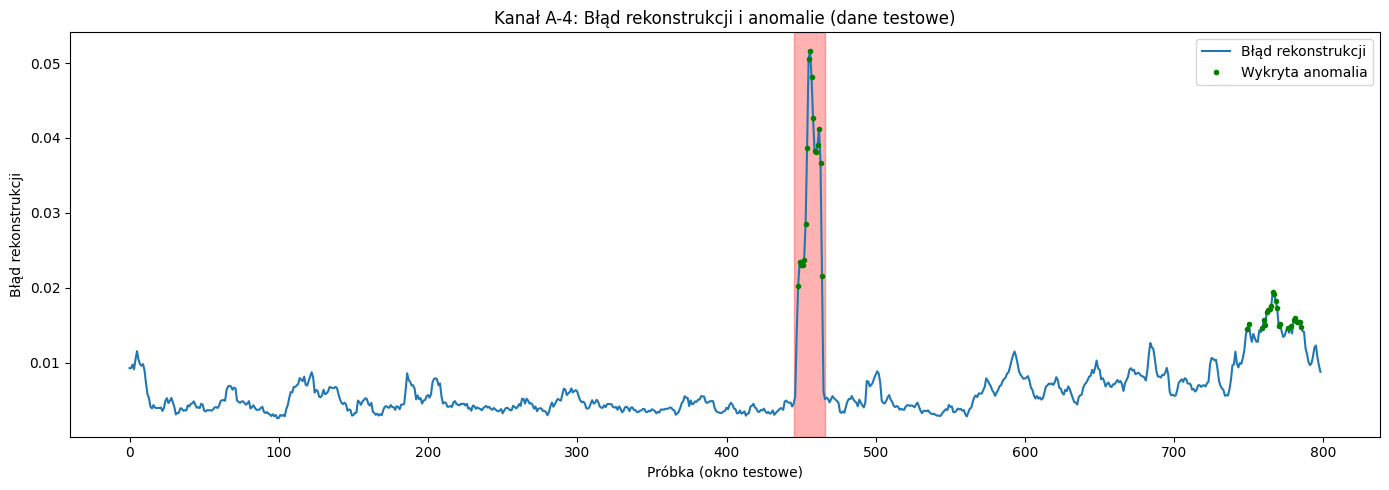

Confusion matrix (test):
[[756  23]
 [  3  17]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.98       779
     Anomaly       0.42      0.85      0.57        20

    accuracy                           0.97       799
   macro avg       0.71      0.91      0.77       799
weighted avg       0.98      0.97      0.97       799

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4550, 4660]: WYKRYTA

Czujnik: G-1
Epoch 12/100, Loss: 0.012465
Epoch 24/100, Loss: 0.006194
Epoch 36/100, Loss: 0.005893
Epoch 48/100, Loss: 0.005739
Epoch 60/100, Loss: 0.005167
Epoch 72/100, Loss: 0.005252
Epoch 84/100, Loss: 0.005172
Epoch 96/100, Loss: 0.005181
Epoch 100/100, Loss: 0.005028
Threshold (percentyl 95) na danych testowych: 0.012271


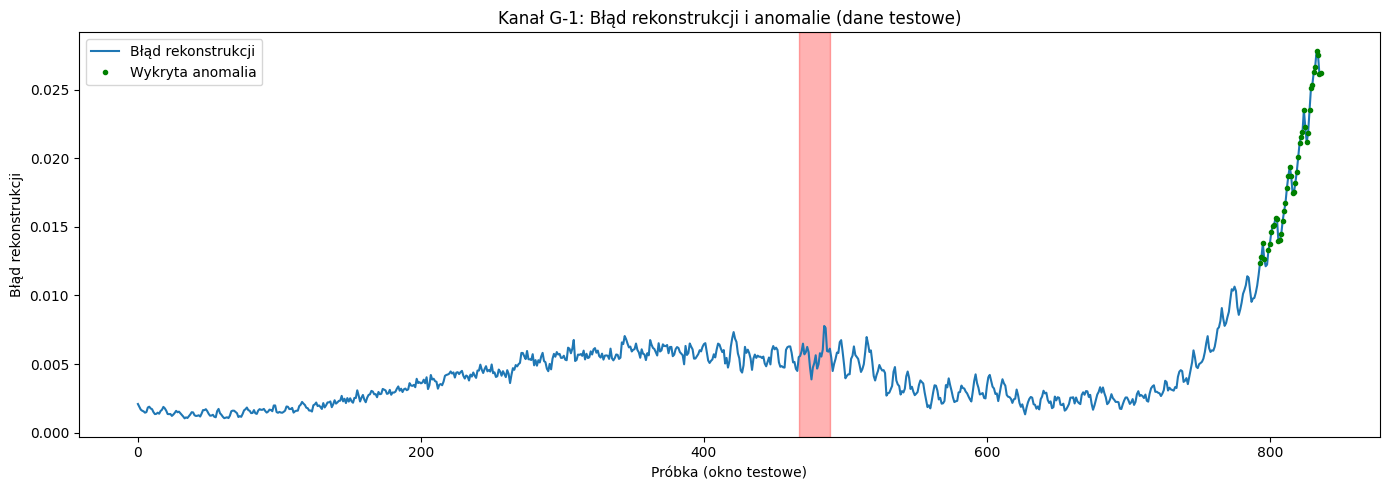

Confusion matrix (test):
[[774  42]
 [ 21   0]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.97      0.95      0.96       816
     Anomaly       0.00      0.00      0.00        21

    accuracy                           0.92       837
   macro avg       0.49      0.47      0.48       837
weighted avg       0.95      0.92      0.94       837

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4770, 4890]: NIEWYKRYTA

Czujnik: G-2
Epoch 12/100, Loss: 0.000000
Epoch 24/100, Loss: 0.000000
Epoch 36/100, Loss: 0.000000
Epoch 48/100, Loss: 0.000000
Epoch 60/100, Loss: 0.000000
Epoch 72/100, Loss: 0.000000
Epoch 84/100, Loss: 0.000000
Epoch 96/100, Loss: 0.000000
Epoch 100/100, Loss: 0.000000
Threshold (percentyl 95) na danych testowych: 0.000000


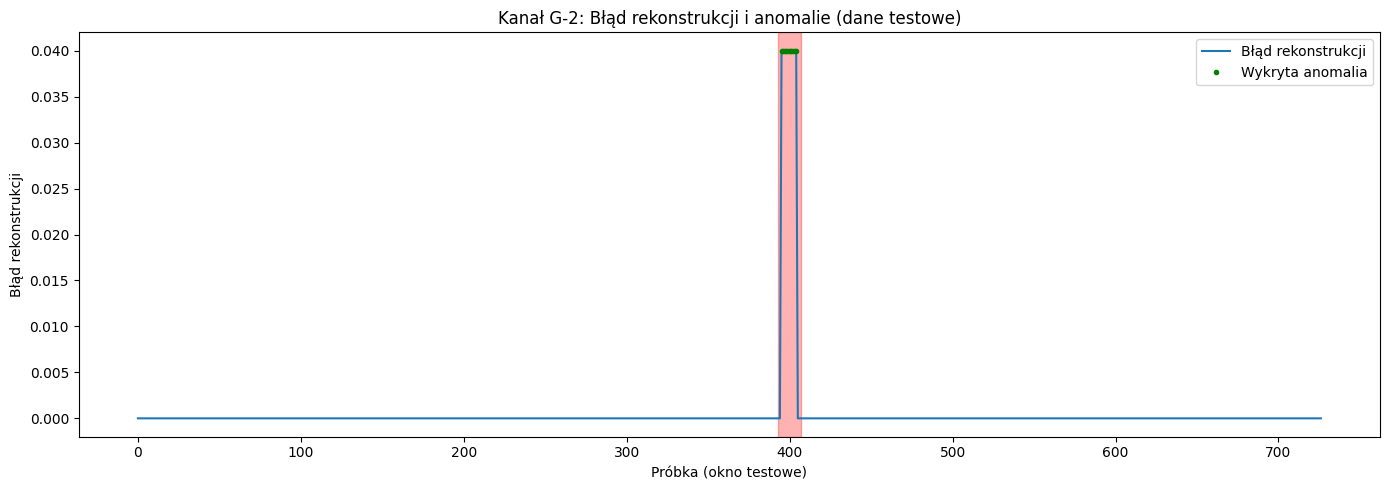

Confusion matrix (test):
[[714   0]
 [  3  10]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       714
     Anomaly       1.00      0.77      0.87        13

    accuracy                           1.00       727
   macro avg       1.00      0.88      0.93       727
weighted avg       1.00      1.00      1.00       727

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4030, 4070]: WYKRYTA

Czujnik: D-5
Epoch 12/100, Loss: 0.009879
Epoch 24/100, Loss: 0.006473
Epoch 36/100, Loss: 0.005789
Epoch 48/100, Loss: 0.005144
Epoch 60/100, Loss: 0.004492
Epoch 72/100, Loss: 0.003511
Epoch 84/100, Loss: 0.003165
Epoch 96/100, Loss: 0.002867
Epoch 100/100, Loss: 0.002911
Threshold (percentyl 95) na danych testowych: 3993422.059497


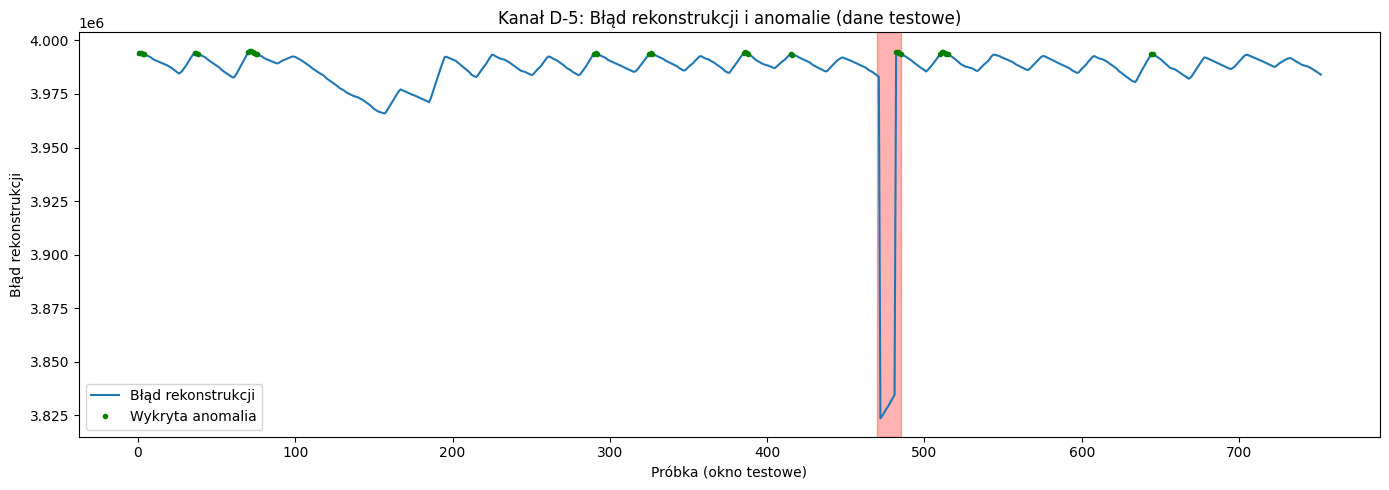

Confusion matrix (test):
[[704  35]
 [ 11   3]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.98      0.95      0.97       739
     Anomaly       0.08      0.21      0.12        14

    accuracy                           0.94       753
   macro avg       0.53      0.58      0.54       753
weighted avg       0.97      0.94      0.95       753

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4800, 4850]: WYKRYTA

Czujnik: D-6
Epoch 12/100, Loss: 0.013086
Epoch 24/100, Loss: 0.007845
Epoch 36/100, Loss: 0.005895
Epoch 48/100, Loss: 0.004836
Epoch 60/100, Loss: 0.004140
Epoch 72/100, Loss: 0.003882
Epoch 84/100, Loss: 0.003535
Epoch 96/100, Loss: 0.002999
Epoch 100/100, Loss: 0.003008
Threshold (percentyl 95) na danych testowych: 0.008697


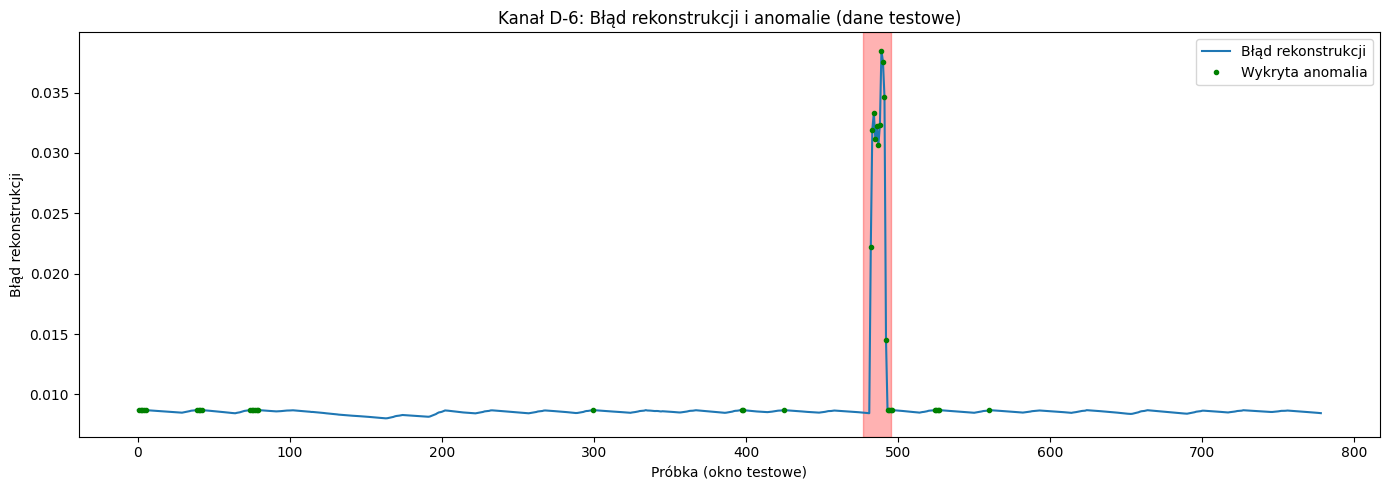

Confusion matrix (test):
[[736  26]
 [  4  13]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98       762
     Anomaly       0.33      0.76      0.46        17

    accuracy                           0.96       779
   macro avg       0.66      0.87      0.72       779
weighted avg       0.98      0.96      0.97       779

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4870, 4950]: WYKRYTA

Czujnik: D-7
Epoch 12/100, Loss: 0.000000
Epoch 24/100, Loss: 0.000000
Epoch 36/100, Loss: 0.000000
Epoch 48/100, Loss: 0.000000
Epoch 60/100, Loss: 0.000000
Epoch 72/100, Loss: 0.000000
Epoch 84/100, Loss: 0.000000
Epoch 96/100, Loss: 0.000000
Epoch 100/100, Loss: 0.000000
Threshold (percentyl 95) na danych testowych: 3.062500


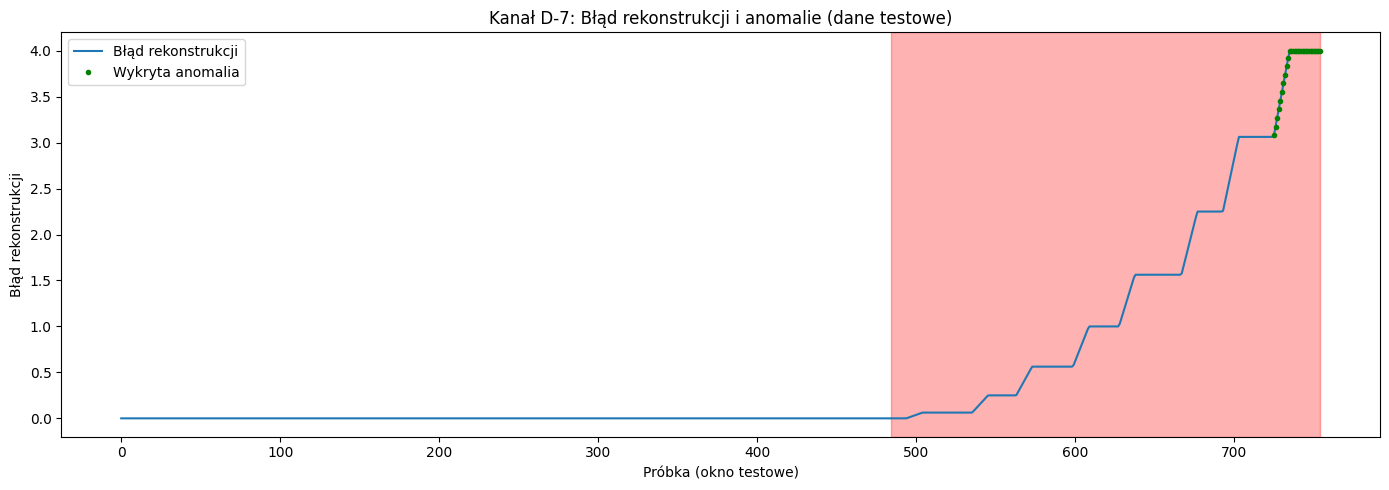

Confusion matrix (test):
[[485   0]
 [240  30]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.67      1.00      0.80       485
     Anomaly       1.00      0.11      0.20       270

    accuracy                           0.68       755
   macro avg       0.83      0.56      0.50       755
weighted avg       0.79      0.68      0.59       755

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4940, 7641]: WYKRYTA

Czujnik: F-1
Epoch 12/100, Loss: 0.034591
Epoch 24/100, Loss: 0.035006
Epoch 36/100, Loss: 0.034824
Epoch 48/100, Loss: 0.035294
Epoch 60/100, Loss: 0.034951
Epoch 72/100, Loss: 0.027338
Epoch 84/100, Loss: 0.026160
Epoch 96/100, Loss: 0.026022
Epoch 100/100, Loss: 0.026062
Threshold (percentyl 95) na danych testowych: 0.033417


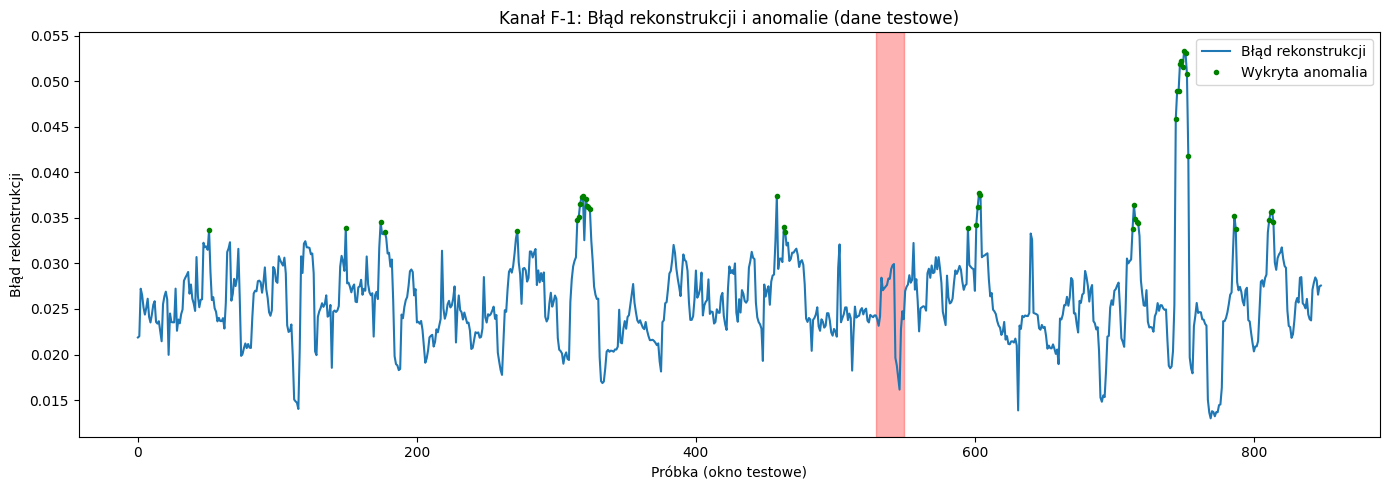

Confusion matrix (test):
[[786  43]
 [ 20   0]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.98      0.95      0.96       829
     Anomaly       0.00      0.00      0.00        20

    accuracy                           0.93       849
   macro avg       0.49      0.47      0.48       849
weighted avg       0.95      0.93      0.94       849

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5392, 5492]: NIEWYKRYTA

Czujnik: P-4
Epoch 12/100, Loss: 0.000000
Epoch 24/100, Loss: 0.000000
Epoch 36/100, Loss: 0.000000
Epoch 48/100, Loss: 0.000000
Epoch 60/100, Loss: 0.000000
Epoch 72/100, Loss: 0.000000
Epoch 84/100, Loss: 0.000000
Epoch 96/100, Loss: 0.000000
Epoch 100/100, Loss: 0.000000
Threshold (percentyl 95) na danych testowych: 0.080000


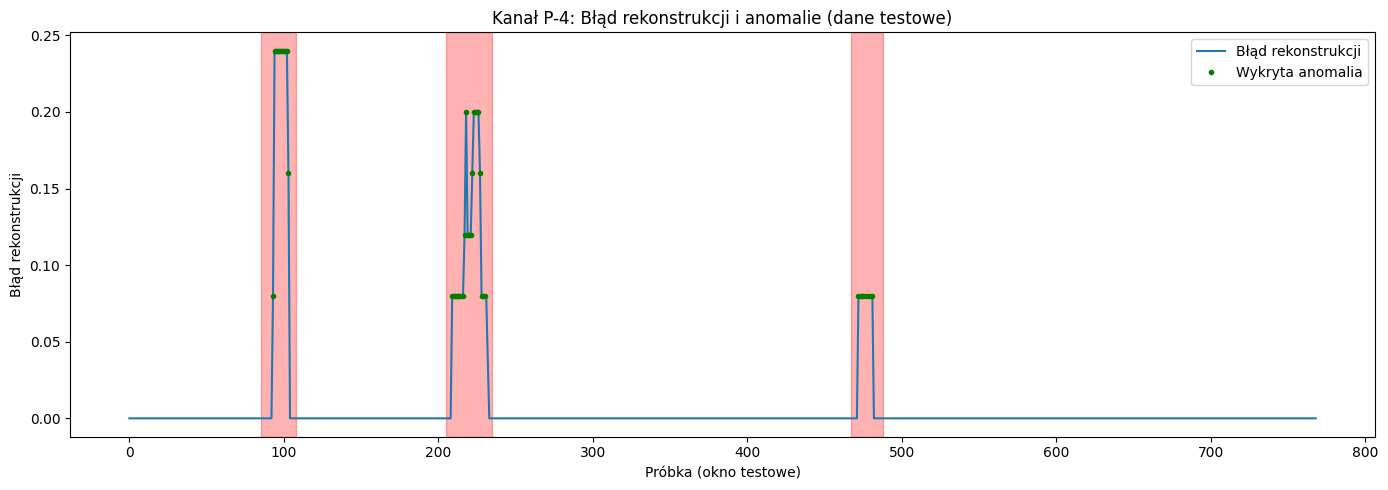

Confusion matrix (test):
[[698   0]
 [ 32  39]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.96      1.00      0.98       698
     Anomaly       1.00      0.55      0.71        71

    accuracy                           0.96       769
   macro avg       0.98      0.77      0.84       769
weighted avg       0.96      0.96      0.95       769

Wynik sprawdzania anomalii względem metadanych:
Anomalia [950, 1080]: WYKRYTA
Anomalia [2150, 2350]: WYKRYTA
Anomalia [4770, 4880]: WYKRYTA

Czujnik: G-3
Epoch 12/100, Loss: 0.006315
Epoch 24/100, Loss: 0.006311
Epoch 36/100, Loss: 0.006308
Epoch 48/100, Loss: 0.006304
Epoch 60/100, Loss: 0.006288
Epoch 72/100, Loss: 0.006369
Epoch 84/100, Loss: 0.006342
Epoch 96/100, Loss: 0.006315
Epoch 100/100, Loss: 0.006311
Threshold (percentyl 95) na danych testowych: 0.000000


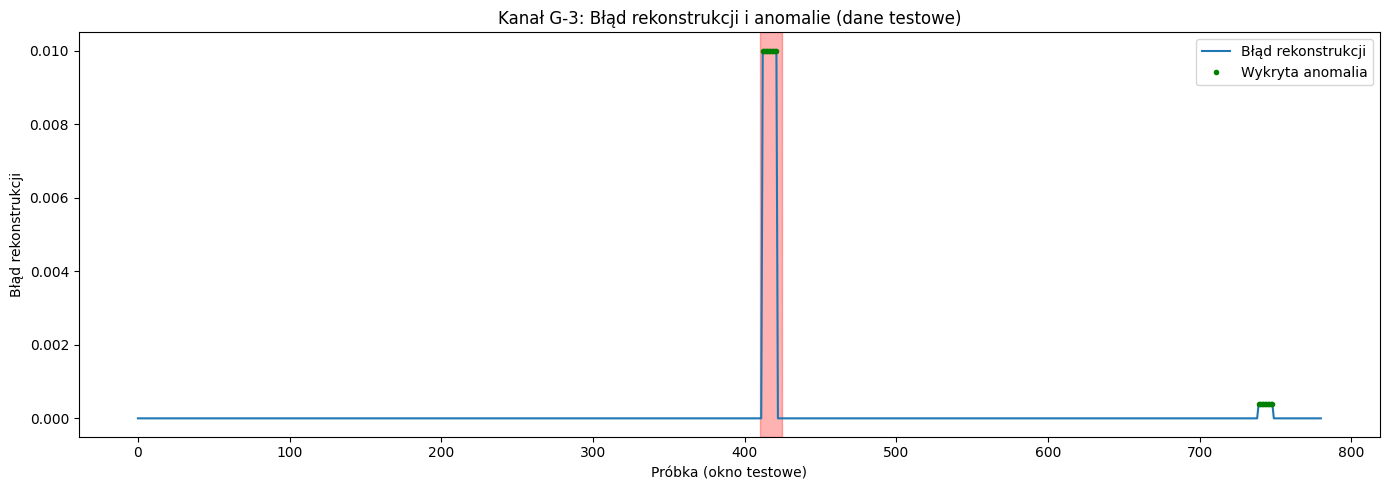

Confusion matrix (test):
[[757  10]
 [  4  10]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       767
     Anomaly       0.50      0.71      0.59        14

    accuracy                           0.98       781
   macro avg       0.75      0.85      0.79       781
weighted avg       0.99      0.98      0.98       781

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4200, 4250]: WYKRYTA

Czujnik: T-1
Epoch 12/100, Loss: 0.092169
Epoch 24/100, Loss: 0.014098
Epoch 36/100, Loss: 0.002666
Epoch 48/100, Loss: 0.002419
Epoch 60/100, Loss: 0.002165
Epoch 72/100, Loss: 0.001827
Epoch 84/100, Loss: 0.001441
Epoch 96/100, Loss: 0.001214
Epoch 100/100, Loss: 0.001167
Threshold (percentyl 95) na danych testowych: 0.006602


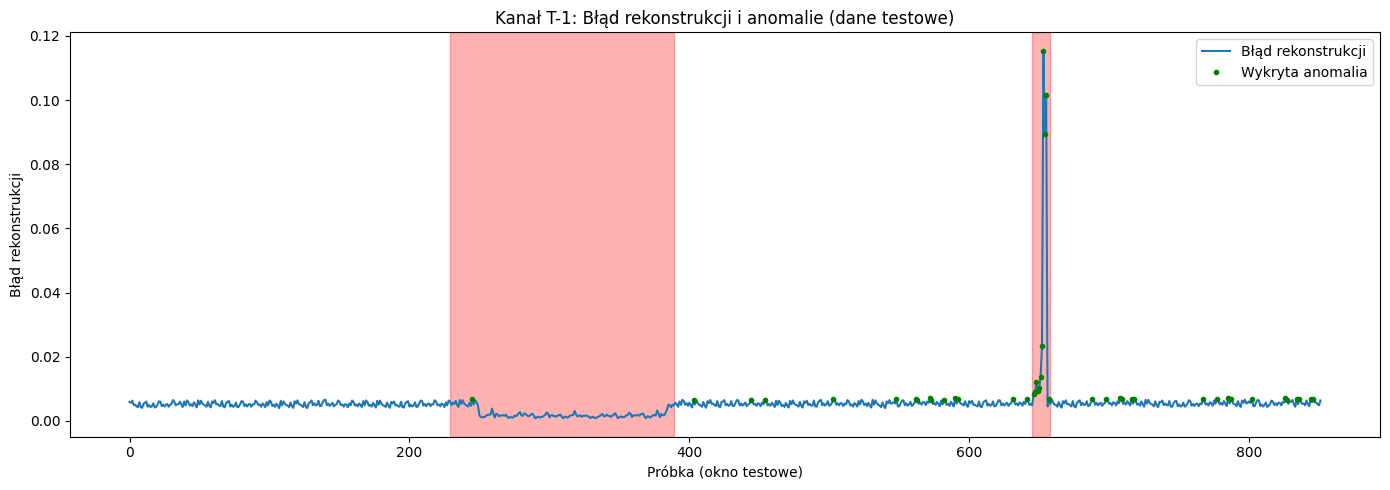

Confusion matrix (test):
[[648  31]
 [161  12]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.80      0.95      0.87       679
     Anomaly       0.28      0.07      0.11       173

    accuracy                           0.77       852
   macro avg       0.54      0.51      0.49       852
weighted avg       0.70      0.77      0.72       852

Wynik sprawdzania anomalii względem metadanych:
Anomalia [2399, 3898]: WYKRYTA
Anomalia [6550, 6585]: WYKRYTA

Czujnik: T-2
Epoch 12/100, Loss: 0.090639
Epoch 24/100, Loss: 0.004257
Epoch 36/100, Loss: 0.003512
Epoch 48/100, Loss: 0.003234
Epoch 60/100, Loss: 0.003052
Epoch 72/100, Loss: 0.002896
Epoch 84/100, Loss: 0.002861
Epoch 96/100, Loss: 0.002164
Epoch 100/100, Loss: 0.002154
Threshold (percentyl 95) na danych testowych: 0.008038


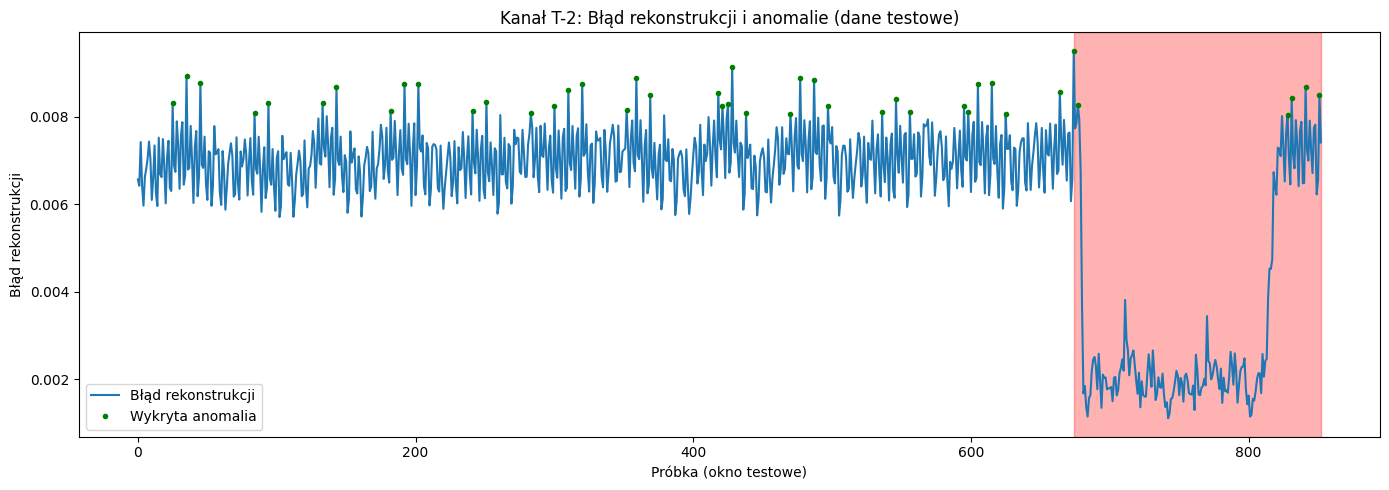

Confusion matrix (test):
[[637  38]
 [173   5]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.79      0.94      0.86       675
     Anomaly       0.12      0.03      0.05       178

    accuracy                           0.75       853
   macro avg       0.45      0.49      0.45       853
weighted avg       0.65      0.75      0.69       853

Wynik sprawdzania anomalii względem metadanych:
Anomalia [6840, 8624]: WYKRYTA

Czujnik: D-8
Epoch 12/100, Loss: 0.000000
Epoch 24/100, Loss: 0.000000
Epoch 36/100, Loss: 0.000000
Epoch 48/100, Loss: 0.000000
Epoch 60/100, Loss: 0.000000
Epoch 72/100, Loss: 0.000000
Epoch 84/100, Loss: 0.000000
Epoch 96/100, Loss: 0.000000
Epoch 100/100, Loss: 0.000000
Threshold (percentyl 95) na danych testowych: 0.000000


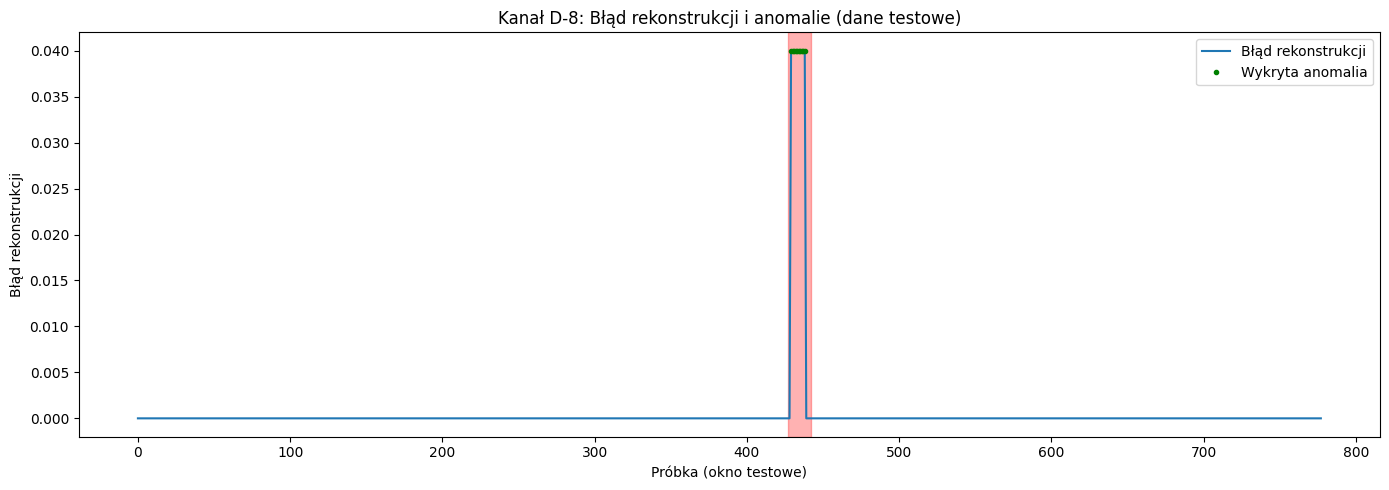

Confusion matrix (test):
[[764   0]
 [  4  10]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00       764
     Anomaly       1.00      0.71      0.83        14

    accuracy                           0.99       778
   macro avg       1.00      0.86      0.92       778
weighted avg       0.99      0.99      0.99       778

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4370, 4420]: WYKRYTA

Czujnik: D-9
Epoch 12/100, Loss: 0.000000
Epoch 24/100, Loss: 0.000000
Epoch 36/100, Loss: 0.000000
Epoch 48/100, Loss: 0.000000
Epoch 60/100, Loss: 0.000000
Epoch 72/100, Loss: 0.000000
Epoch 84/100, Loss: 0.000000
Epoch 96/100, Loss: 0.000000
Epoch 100/100, Loss: 0.000000
Threshold (percentyl 95) na danych testowych: 4.000000


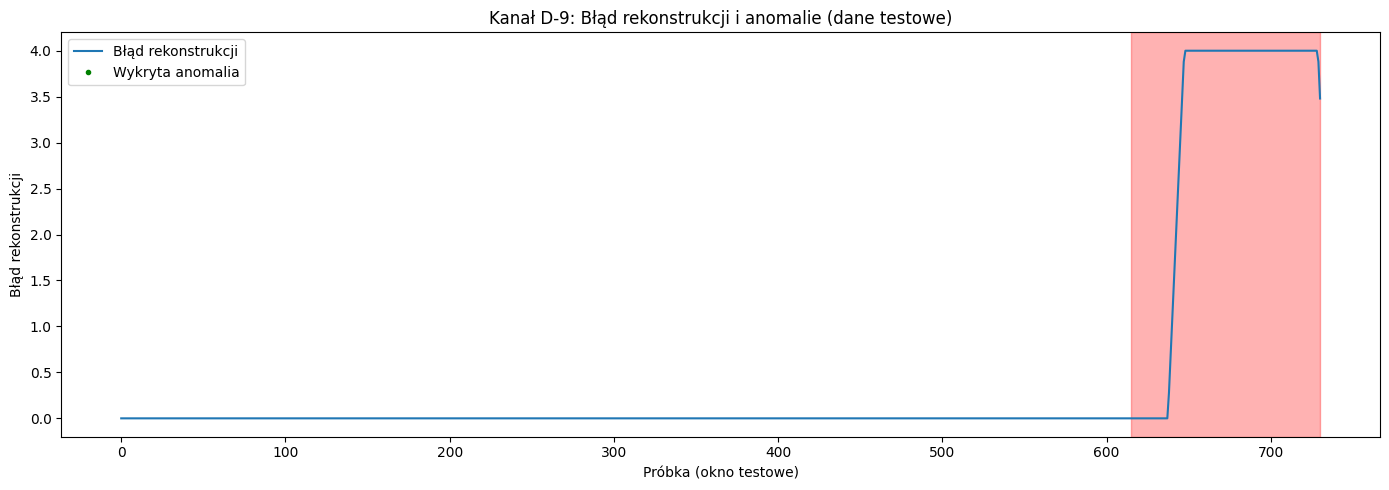

Confusion matrix (test):
[[616   0]
 [115   0]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.84      1.00      0.91       616
     Anomaly       0.00      0.00      0.00       115

    accuracy                           0.84       731
   macro avg       0.42      0.50      0.46       731
weighted avg       0.71      0.84      0.77       731

Wynik sprawdzania anomalii względem metadanych:
Anomalia [6250, 7405]: NIEWYKRYTA

Czujnik: F-2


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 12/100, Loss: 0.033738
Epoch 24/100, Loss: 0.033693
Epoch 36/100, Loss: 0.033742
Epoch 48/100, Loss: 0.033577
Epoch 60/100, Loss: 0.033707
Epoch 72/100, Loss: 0.034241
Epoch 84/100, Loss: 0.034179
Epoch 96/100, Loss: 0.034766
Epoch 100/100, Loss: 0.034207
Threshold (percentyl 95) na danych testowych: 0.067212


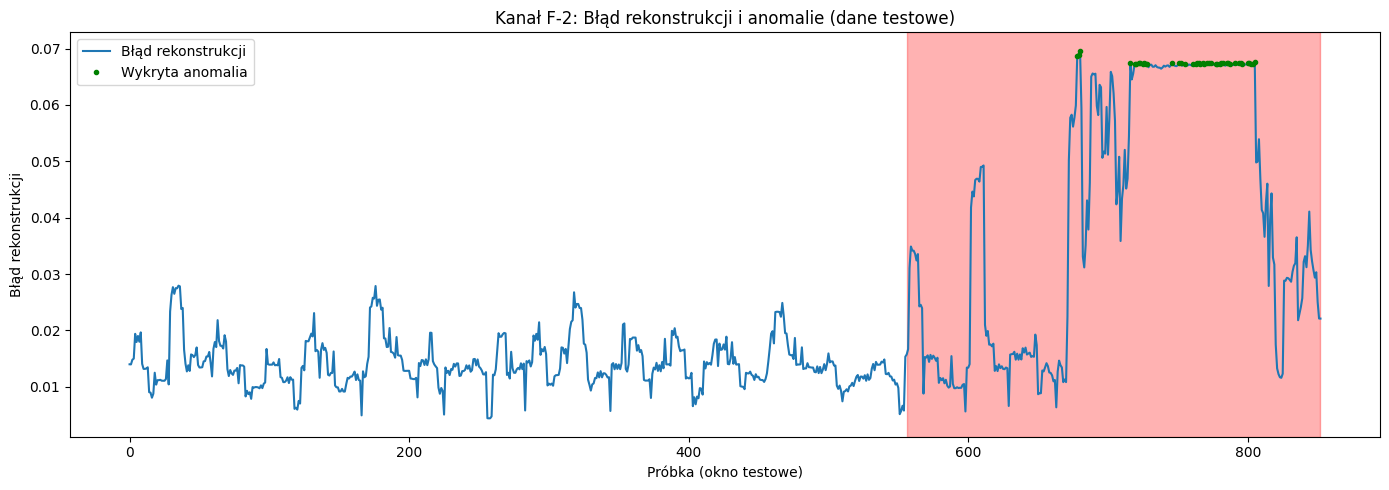

Confusion matrix (test):
[[557   0]
 [253  43]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.69      1.00      0.81       557
     Anomaly       1.00      0.15      0.25       296

    accuracy                           0.70       853
   macro avg       0.84      0.57      0.53       853
weighted avg       0.80      0.70      0.62       853

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5669, 8625]: WYKRYTA

Czujnik: G-4
Epoch 12/100, Loss: 0.062982
Epoch 24/100, Loss: 0.035843
Epoch 36/100, Loss: 0.034501
Epoch 48/100, Loss: 0.033577
Epoch 60/100, Loss: 0.032796
Epoch 72/100, Loss: 0.031912
Epoch 84/100, Loss: 0.030903
Epoch 96/100, Loss: 0.030609
Epoch 100/100, Loss: 0.029890
Threshold (percentyl 95) na danych testowych: 0.063828


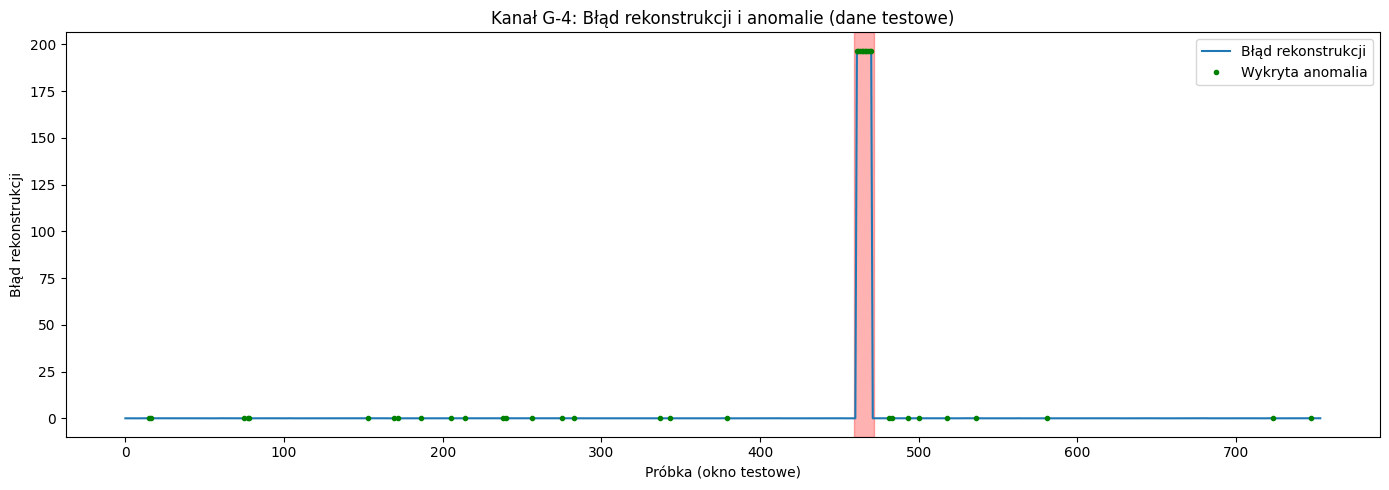

Confusion matrix (test):
[[714  28]
 [  2  10]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98       742
     Anomaly       0.26      0.83      0.40        12

    accuracy                           0.96       754
   macro avg       0.63      0.90      0.69       754
weighted avg       0.99      0.96      0.97       754

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4690, 4720]: WYKRYTA

Czujnik: T-3
Epoch 12/100, Loss: 0.002426
Epoch 24/100, Loss: 0.001100
Epoch 36/100, Loss: 0.001025
Epoch 48/100, Loss: 0.000963
Epoch 60/100, Loss: 0.000913
Epoch 72/100, Loss: 0.000870
Epoch 84/100, Loss: 0.000844
Epoch 96/100, Loss: 0.000823
Epoch 100/100, Loss: 0.000779
Threshold (percentyl 95) na danych testowych: 0.010427


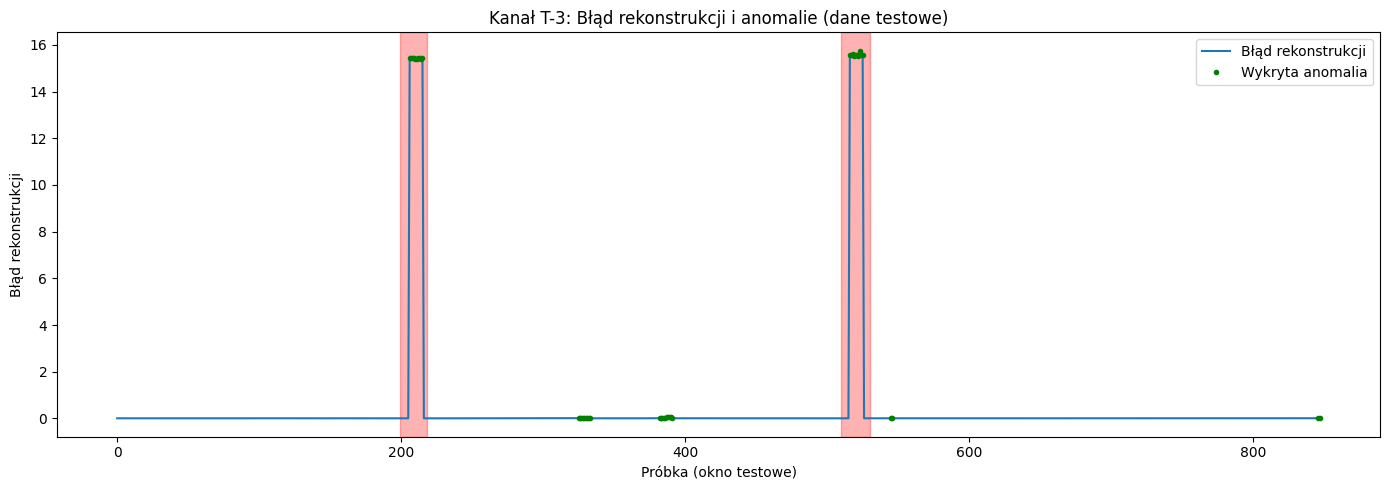

Confusion matrix (test):
[[788  23]
 [ 17  20]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.98      0.97      0.98       811
     Anomaly       0.47      0.54      0.50        37

    accuracy                           0.95       848
   macro avg       0.72      0.76      0.74       848
weighted avg       0.96      0.95      0.95       848

Wynik sprawdzania anomalii względem metadanych:
Anomalia [2098, 2180]: WYKRYTA
Anomalia [5200, 5300]: WYKRYTA

Czujnik: D-11
Epoch 12/100, Loss: 0.003558
Epoch 24/100, Loss: 0.001333
Epoch 36/100, Loss: 0.001121
Epoch 48/100, Loss: 0.000939
Epoch 60/100, Loss: 0.001063
Epoch 72/100, Loss: 0.000760
Epoch 84/100, Loss: 0.000734
Epoch 96/100, Loss: 0.000871
Epoch 100/100, Loss: 0.000850
Threshold (percentyl 95) na danych testowych: 0.002135


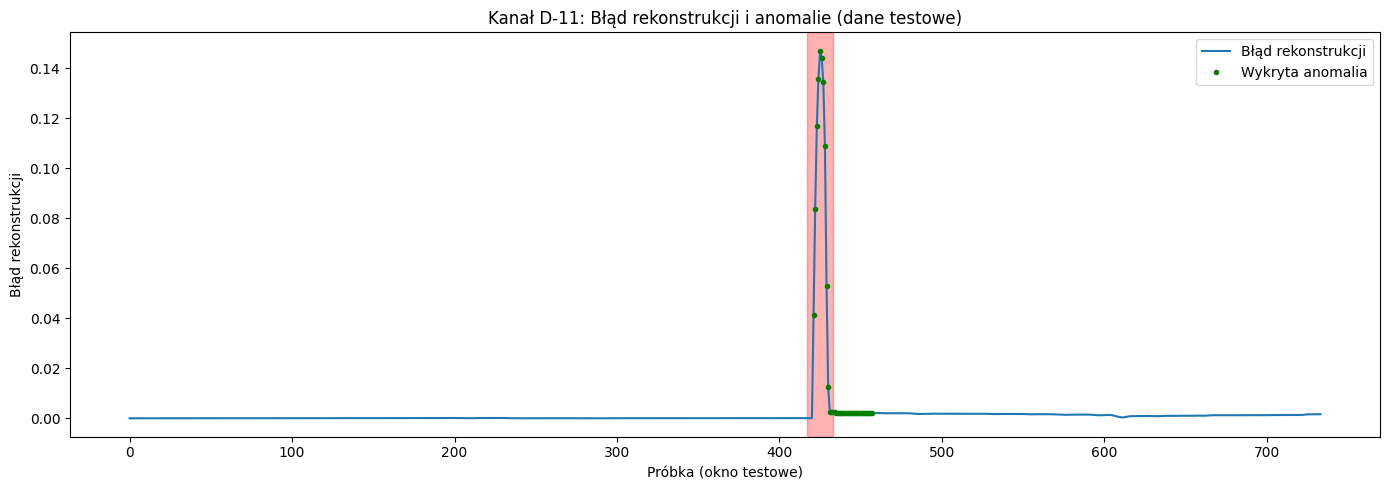

Confusion matrix (test):
[[694  25]
 [  3  12]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.98       719
     Anomaly       0.32      0.80      0.46        15

    accuracy                           0.96       734
   macro avg       0.66      0.88      0.72       734
weighted avg       0.98      0.96      0.97       734

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4270, 4330]: WYKRYTA

Czujnik: D-12
Epoch 12/100, Loss: 0.194235
Epoch 24/100, Loss: 0.014549
Epoch 36/100, Loss: 0.000000
Epoch 48/100, Loss: 0.000000
Epoch 60/100, Loss: 0.000000
Epoch 72/100, Loss: 0.000000
Epoch 84/100, Loss: 0.000000
Epoch 96/100, Loss: 0.000000
Epoch 100/100, Loss: 0.000000
Threshold (percentyl 95) na danych testowych: 3.062480


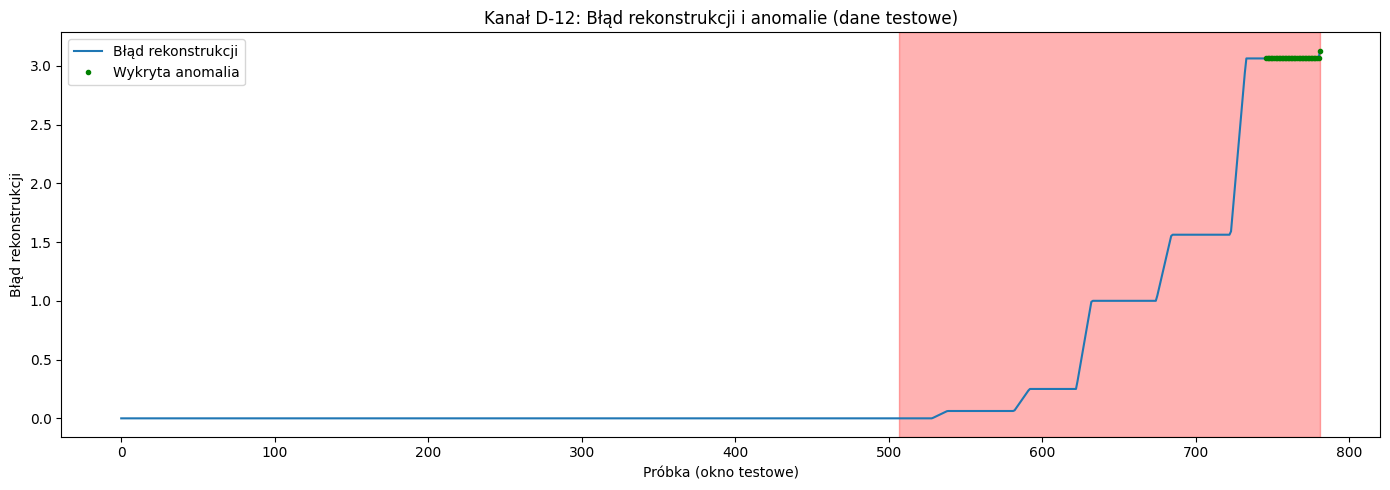

Confusion matrix (test):
[[508   0]
 [238  36]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.68      1.00      0.81       508
     Anomaly       1.00      0.13      0.23       274

    accuracy                           0.70       782
   macro avg       0.84      0.57      0.52       782
weighted avg       0.79      0.70      0.61       782

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5178, 7917]: WYKRYTA

Czujnik: B-1
Epoch 12/100, Loss: 0.000000
Epoch 24/100, Loss: 0.000000
Epoch 36/100, Loss: 0.000000
Epoch 48/100, Loss: 0.000000
Epoch 60/100, Loss: 0.000000
Epoch 72/100, Loss: 0.000000
Epoch 84/100, Loss: 0.000000
Epoch 96/100, Loss: 0.000000
Epoch 100/100, Loss: 0.000000
Threshold (percentyl 95) na danych testowych: 4.000000


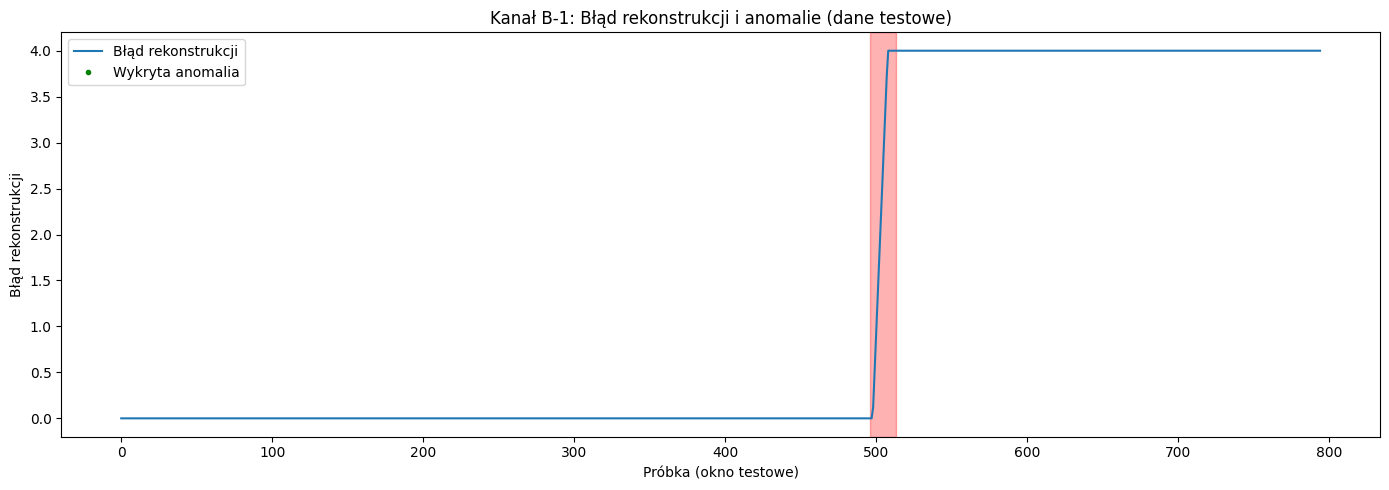

Confusion matrix (test):
[[779   0]
 [ 16   0]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99       779
     Anomaly       0.00      0.00      0.00        16

    accuracy                           0.98       795
   macro avg       0.49      0.50      0.49       795
weighted avg       0.96      0.98      0.97       795

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5060, 5130]: NIEWYKRYTA

Czujnik: G-6


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 12/100, Loss: 0.001806
Epoch 24/100, Loss: 0.000417
Epoch 36/100, Loss: 0.000381
Epoch 48/100, Loss: 0.000261
Epoch 60/100, Loss: 0.000236
Epoch 72/100, Loss: 0.000201
Epoch 84/100, Loss: 0.000247
Epoch 96/100, Loss: 0.000162
Epoch 100/100, Loss: 0.000292
Threshold (percentyl 95) na danych testowych: 0.001866


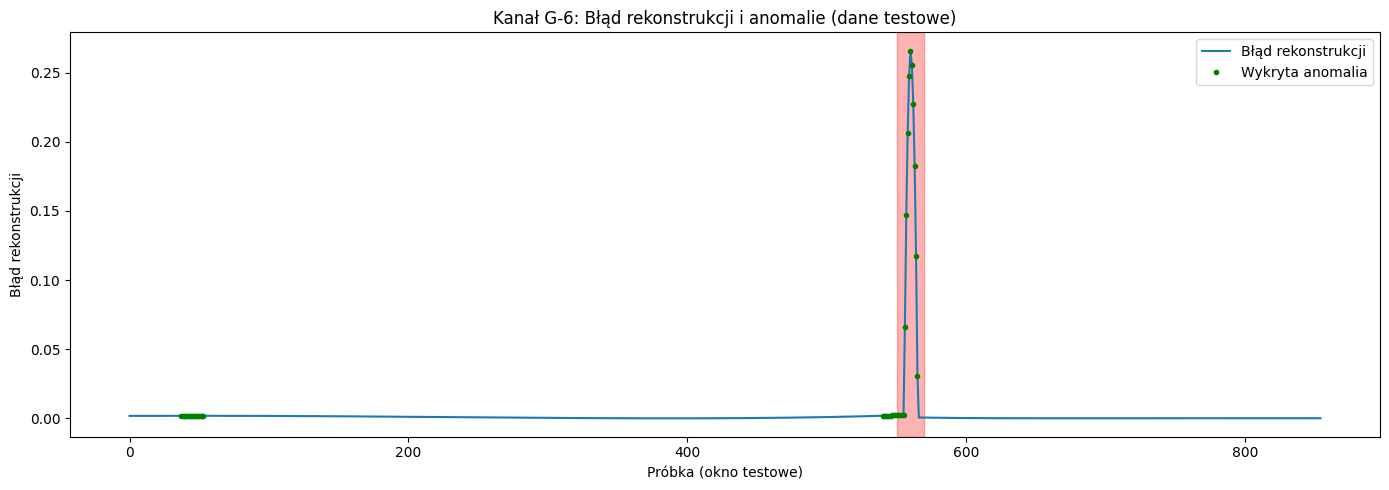

Confusion matrix (test):
[[808  28]
 [  4  15]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.98       836
     Anomaly       0.35      0.79      0.48        19

    accuracy                           0.96       855
   macro avg       0.67      0.88      0.73       855
weighted avg       0.98      0.96      0.97       855

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5600, 5700]: WYKRYTA

Czujnik: G-7
Epoch 12/100, Loss: 0.007751
Epoch 24/100, Loss: 0.007706
Epoch 36/100, Loss: 0.007838
Epoch 48/100, Loss: 0.007730
Epoch 60/100, Loss: 0.007649
Epoch 72/100, Loss: 0.007764
Epoch 84/100, Loss: 0.007804
Epoch 96/100, Loss: 0.007747
Epoch 100/100, Loss: 0.007577
Threshold (percentyl 95) na danych testowych: 0.030480


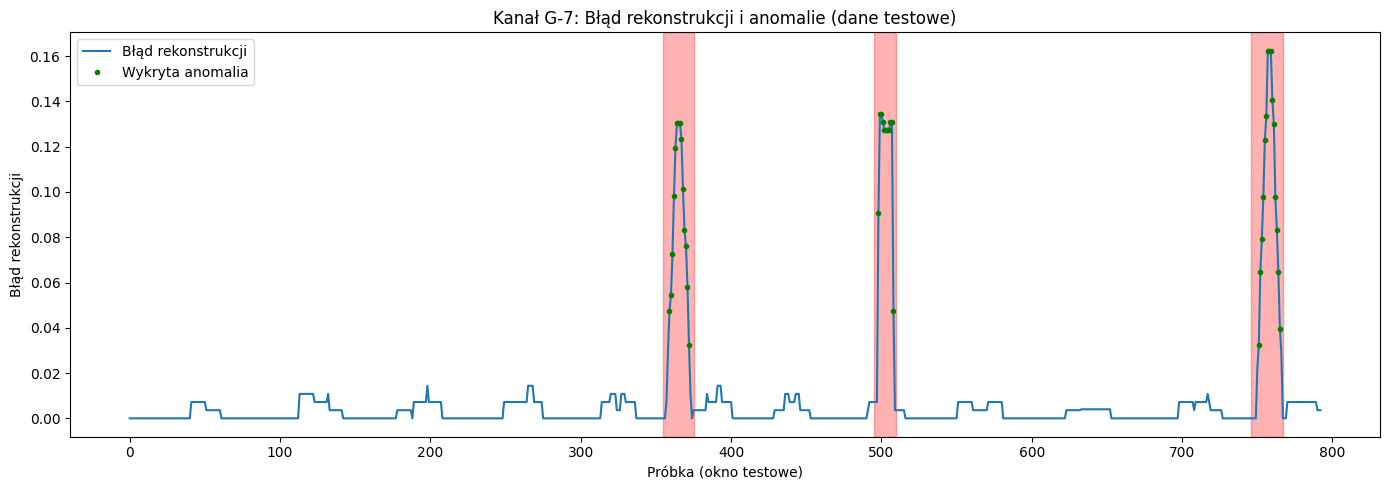

Confusion matrix (test):
[[739   0]
 [ 14  40]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99       739
     Anomaly       1.00      0.74      0.85        54

    accuracy                           0.98       793
   macro avg       0.99      0.87      0.92       793
weighted avg       0.98      0.98      0.98       793

Wynik sprawdzania anomalii względem metadanych:
Anomalia [3650, 3750]: WYKRYTA
Anomalia [5050, 5100]: WYKRYTA
Anomalia [7560, 7675]: WYKRYTA

Czujnik: P-7
Epoch 12/100, Loss: 0.002191
Epoch 24/100, Loss: 0.001744
Epoch 36/100, Loss: 0.001543
Epoch 48/100, Loss: 0.001449
Epoch 60/100, Loss: 0.001395
Epoch 72/100, Loss: 0.001257
Epoch 84/100, Loss: 0.001311
Epoch 96/100, Loss: 0.001194
Epoch 100/100, Loss: 0.001277
Threshold (percentyl 95) na danych testowych: 0.014243


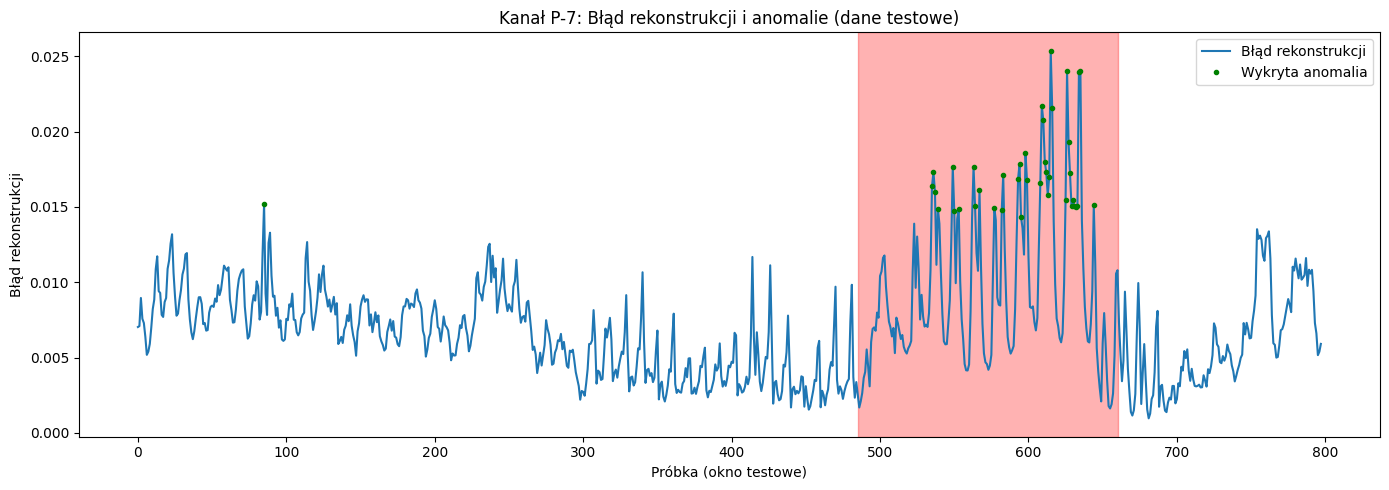

Confusion matrix (test):
[[623   1]
 [135  39]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.82      1.00      0.90       624
     Anomaly       0.97      0.22      0.36       174

    accuracy                           0.83       798
   macro avg       0.90      0.61      0.63       798
weighted avg       0.86      0.83      0.78       798

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4950, 6600]: WYKRYTA

Czujnik: R-1
Epoch 12/100, Loss: 0.000000
Epoch 24/100, Loss: 0.000000
Epoch 36/100, Loss: 0.000000
Epoch 48/100, Loss: 0.000000
Epoch 60/100, Loss: 0.000000
Epoch 72/100, Loss: 0.000000
Epoch 84/100, Loss: 0.000000
Epoch 96/100, Loss: 0.000000
Epoch 100/100, Loss: 0.000000
Threshold (percentyl 95) na danych testowych: 0.000001


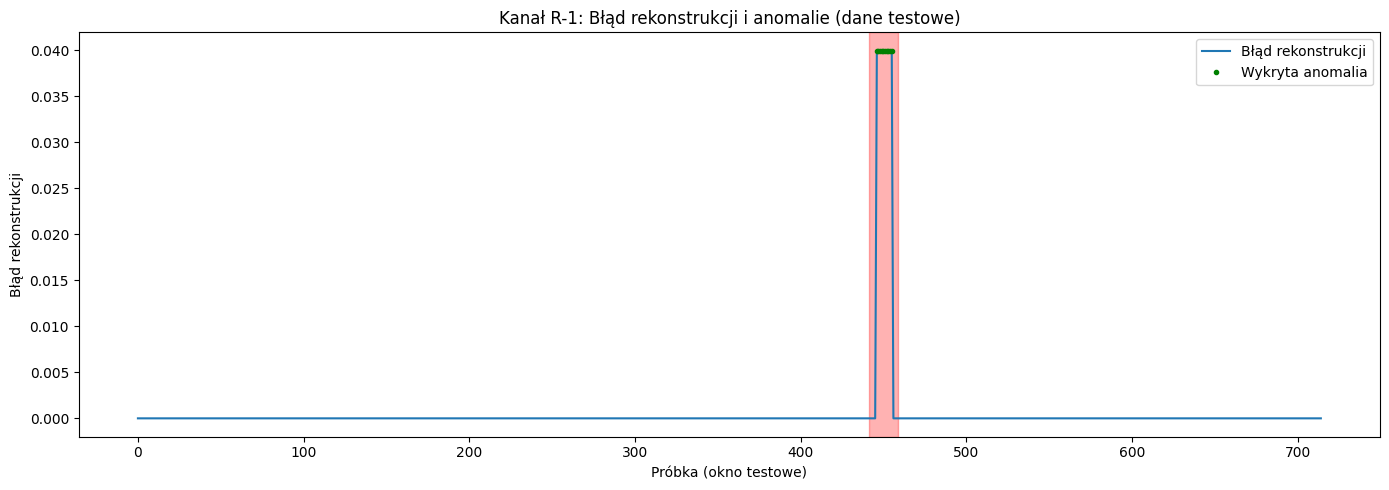

Confusion matrix (test):
[[698   0]
 [  7  10]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00       698
     Anomaly       1.00      0.59      0.74        17

    accuracy                           0.99       715
   macro avg       1.00      0.79      0.87       715
weighted avg       0.99      0.99      0.99       715

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4510, 4590]: WYKRYTA

Czujnik: A-5
Epoch 12/100, Loss: 0.018615
Epoch 24/100, Loss: 0.004135
Epoch 36/100, Loss: 0.004006
Epoch 48/100, Loss: 0.003777
Epoch 60/100, Loss: 0.003615
Epoch 72/100, Loss: 0.003497
Epoch 84/100, Loss: 0.003417
Epoch 96/100, Loss: 0.003332
Epoch 100/100, Loss: 0.003297
Threshold (percentyl 95) na danych testowych: 2225048.320993


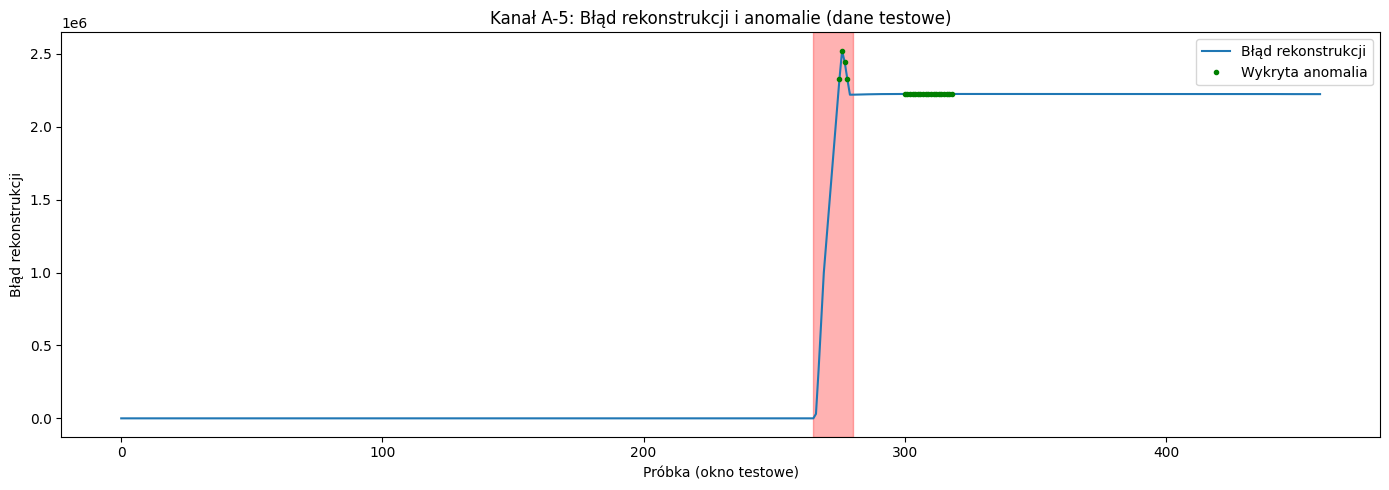

Confusion matrix (test):
[[427  19]
 [ 10   4]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.98      0.96      0.97       446
     Anomaly       0.17      0.29      0.22        14

    accuracy                           0.94       460
   macro avg       0.58      0.62      0.59       460
weighted avg       0.95      0.94      0.94       460

Wynik sprawdzania anomalii względem metadanych:
Anomalia [2750, 2800]: WYKRYTA

Czujnik: A-6
Epoch 12/100, Loss: 0.138153
Epoch 24/100, Loss: 0.004897
Epoch 36/100, Loss: 0.006984
Epoch 48/100, Loss: 0.006987
Epoch 60/100, Loss: 0.006987
Epoch 72/100, Loss: 0.006987
Epoch 84/100, Loss: 0.006987
Epoch 96/100, Loss: 0.006987
Epoch 100/100, Loss: 0.006987
Threshold (percentyl 95) na danych testowych: 0.213798


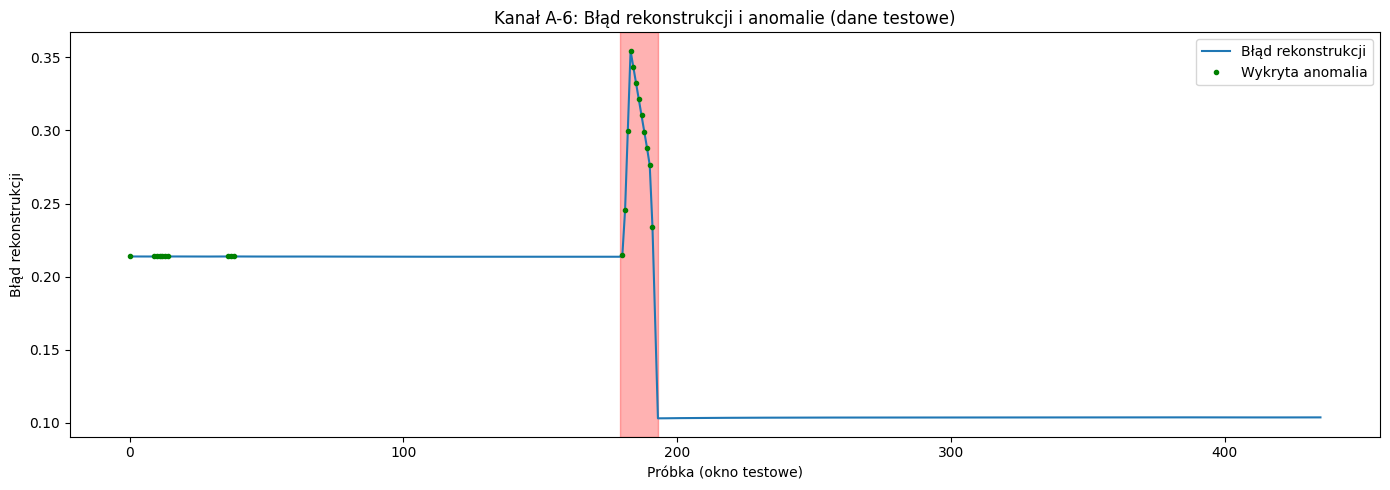

Confusion matrix (test):
[[413  10]
 [  1  12]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99       423
     Anomaly       0.55      0.92      0.69        13

    accuracy                           0.97       436
   macro avg       0.77      0.95      0.84       436
weighted avg       0.98      0.97      0.98       436

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1890, 1930]: WYKRYTA

Czujnik: A-7
Epoch 12/100, Loss: 0.038112
Epoch 24/100, Loss: 0.026841
Epoch 36/100, Loss: 0.020925
Epoch 48/100, Loss: 0.019243
Epoch 60/100, Loss: 0.014981
Epoch 72/100, Loss: 0.012214
Epoch 84/100, Loss: 0.010276
Epoch 96/100, Loss: 0.008704
Epoch 100/100, Loss: 0.008212
Threshold (percentyl 95) na danych testowych: 0.038393


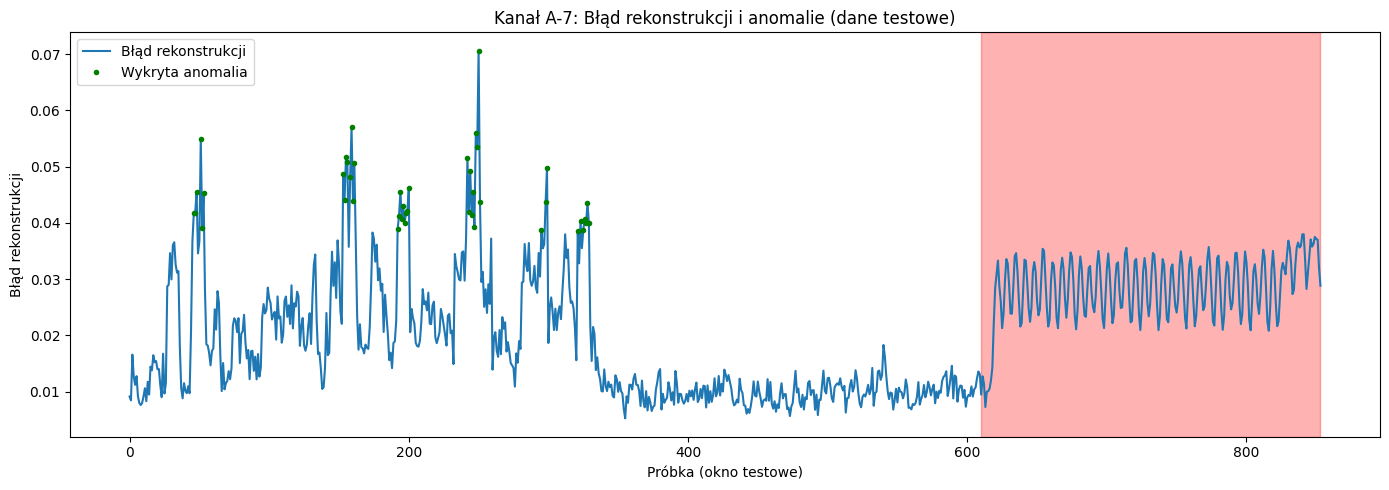

Confusion matrix (test):
[[568  43]
 [243   0]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.70      0.93      0.80       611
     Anomaly       0.00      0.00      0.00       243

    accuracy                           0.67       854
   macro avg       0.35      0.46      0.40       854
weighted avg       0.50      0.67      0.57       854

Wynik sprawdzania anomalii względem metadanych:
Anomalia [6200, 8600]: NIEWYKRYTA

Czujnik: D-13
Epoch 12/100, Loss: 0.000001
Epoch 24/100, Loss: 0.000000
Epoch 36/100, Loss: 0.000000
Epoch 48/100, Loss: 0.000000
Epoch 60/100, Loss: 0.000000
Epoch 72/100, Loss: 0.000000
Epoch 84/100, Loss: 0.000000
Epoch 96/100, Loss: 0.000000
Epoch 100/100, Loss: 0.000000
Threshold (percentyl 95) na danych testowych: 4.000000


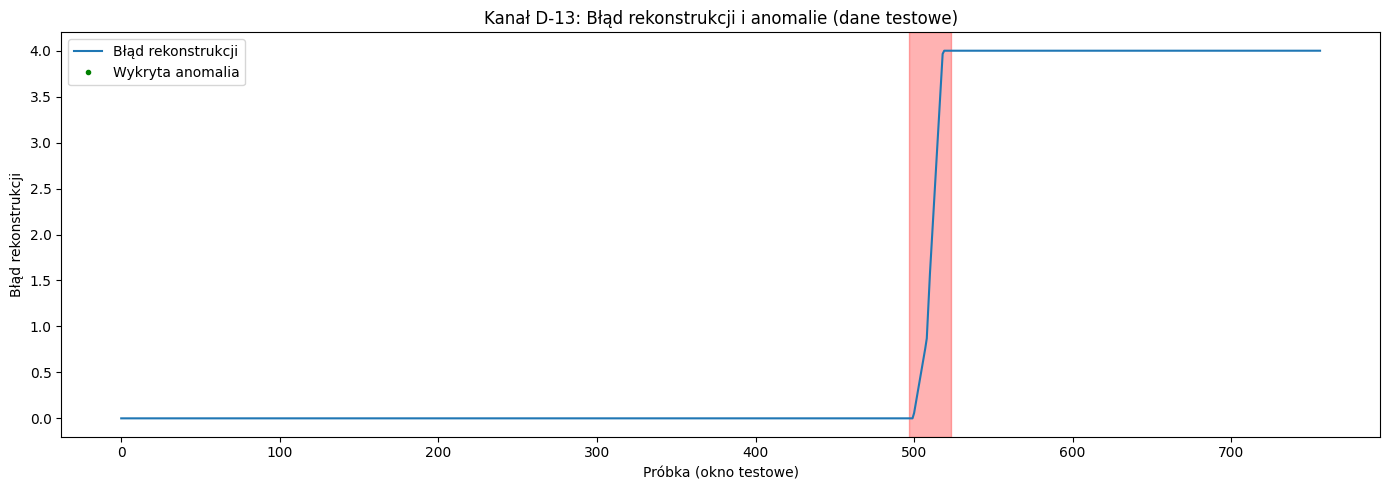

Confusion matrix (test):
[[732   0]
 [ 25   0]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98       732
     Anomaly       0.00      0.00      0.00        25

    accuracy                           0.97       757
   macro avg       0.48      0.50      0.49       757
weighted avg       0.94      0.97      0.95       757

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5070, 5230]: NIEWYKRYTA

Czujnik: A-8
Epoch 12/100, Loss: 0.112702
Epoch 24/100, Loss: 0.007525


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 36/100, Loss: 0.019682
Epoch 48/100, Loss: 0.007043
Epoch 60/100, Loss: 0.002608
Epoch 72/100, Loss: 0.004204
Epoch 84/100, Loss: 0.006885
Epoch 96/100, Loss: 0.023071
Epoch 100/100, Loss: 0.020923
Threshold (percentyl 95) na danych testowych: 0.530134


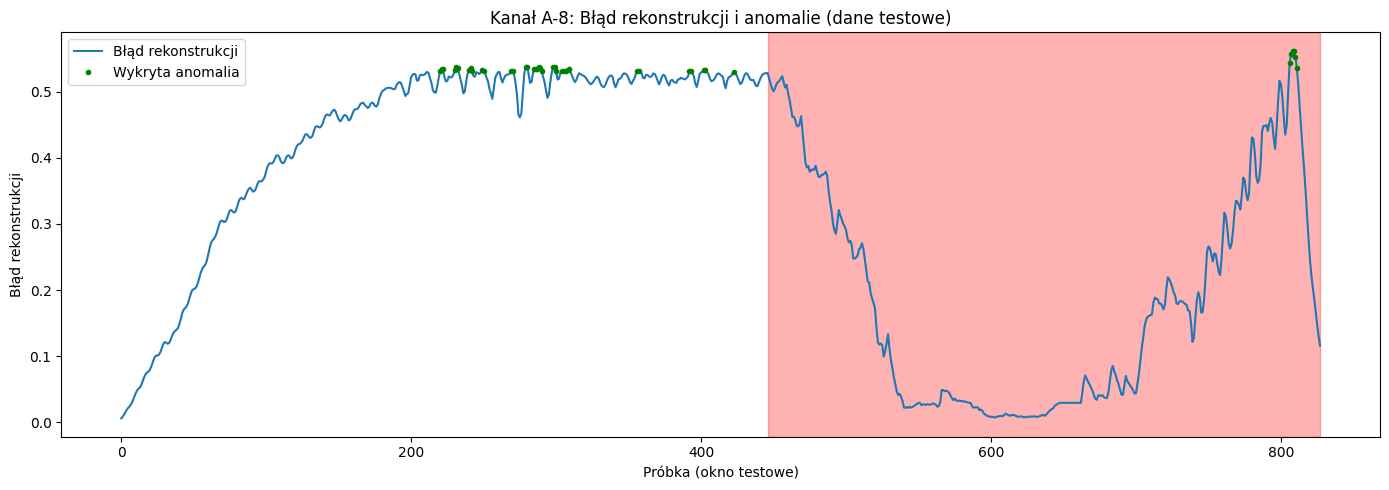

Confusion matrix (test):
[[411  36]
 [375   6]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.52      0.92      0.67       447
     Anomaly       0.14      0.02      0.03       381

    accuracy                           0.50       828
   macro avg       0.33      0.47      0.35       828
weighted avg       0.35      0.50      0.37       828

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4569, 8374]: WYKRYTA

Czujnik: A-9
Epoch 12/100, Loss: 0.056019
Epoch 24/100, Loss: 0.038209
Epoch 36/100, Loss: 0.007569
Epoch 48/100, Loss: 0.008073
Epoch 60/100, Loss: 0.007304
Epoch 72/100, Loss: 0.035770
Epoch 84/100, Loss: 0.007688
Epoch 96/100, Loss: 0.035794
Epoch 100/100, Loss: 0.010204
Threshold (percentyl 95) na danych testowych: 0.526136


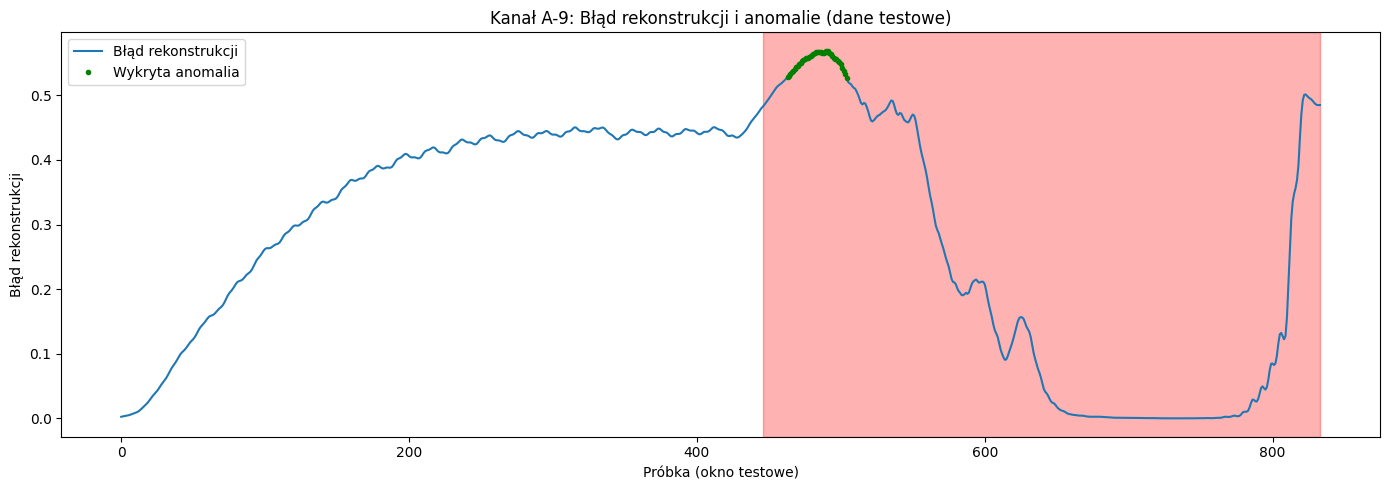

Confusion matrix (test):
[[447   0]
 [345  42]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.56      1.00      0.72       447
     Anomaly       1.00      0.11      0.20       387

    accuracy                           0.59       834
   macro avg       0.78      0.55      0.46       834
weighted avg       0.77      0.59      0.48       834

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4569, 8433]: WYKRYTA

Czujnik: F-3
Epoch 12/100, Loss: 0.001592
Epoch 24/100, Loss: 0.000643
Epoch 36/100, Loss: 0.000450
Epoch 48/100, Loss: 0.000849
Epoch 60/100, Loss: 0.000358
Epoch 72/100, Loss: 0.000215
Epoch 84/100, Loss: 0.000369
Epoch 96/100, Loss: 0.000168
Epoch 100/100, Loss: 0.000177
Threshold (percentyl 95) na danych testowych: 0.002198


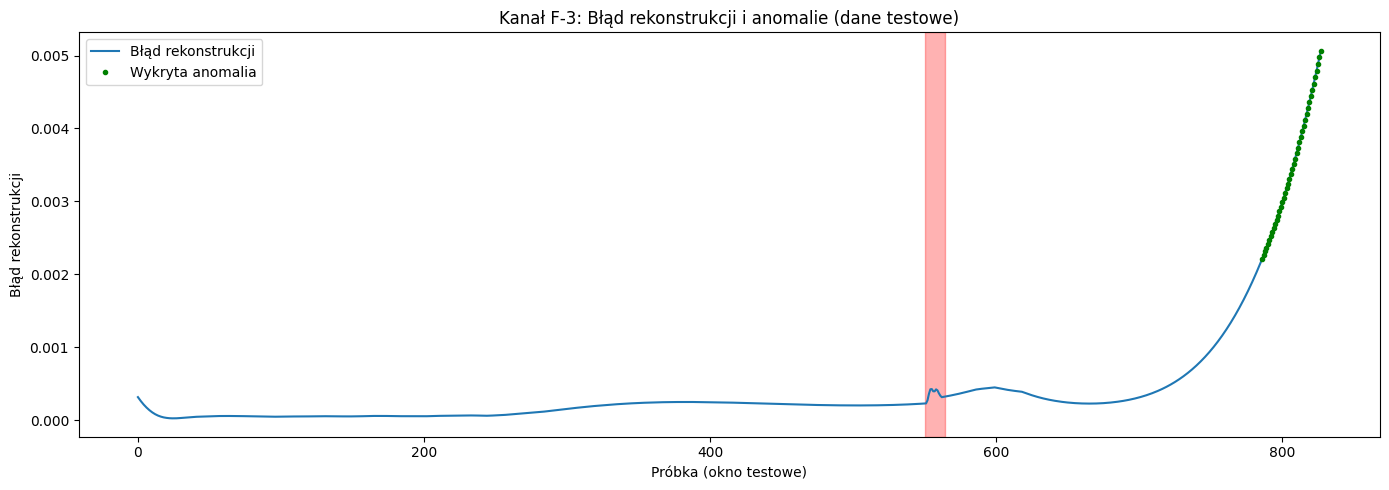

Confusion matrix (test):
[[773  42]
 [ 13   0]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.98      0.95      0.97       815
     Anomaly       0.00      0.00      0.00        13

    accuracy                           0.93       828
   macro avg       0.49      0.47      0.48       828
weighted avg       0.97      0.93      0.95       828

Wynik sprawdzania anomalii względem metadanych:
Anomalia [5600, 5640]: NIEWYKRYTA

PODSUMOWANIE DLA WSZYSTKICH CZUJNIKÓW
Wszystkich anomalii:: 67
Wykrytych anomalii:: 57
Niewykrytych anomali: 10


In [19]:
# Parametry do ustawienia
batch_size = 64
epochs = 100 
threshold_percentile = 95
window_size = 100
window_step = 10 
learning_rate = 1e-3

use_first_column = True  # jeśli True bierze tylko pierwszą kolumnę danych telemetrycznych

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import csv
import numpy as np

# Funkcja tworząca okna czasowe
def create_windows(data, window_size, step_size):
    windows = []
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end])
    return np.array(windows)

# Definicja modelu Autoenkodera
class UniversalAE(nn.Module):
    def __init__(self, input_dim):
        super(UniversalAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

total_anomalies = 0
detected_anomalies = 0
results = []

# Pętla po wszystkich czujnikach
for sensor_name in smap_channels:
    print(f"\n{'='*40}\nCzujnik: {sensor_name}\n{'='*40}")

    # Przygotowanie danych
    train_data = smap_train_data[sensor_name]
    sensor_test_data = smap_test_data[sensor_name]

    if use_first_column:
        train_data = train_data[:, 0].reshape(-1, 1)
        sensor_test_data = sensor_test_data[:, 0].reshape(-1, 1)

    scaler = MinMaxScaler()
    arr_norm = scaler.fit_transform(train_data)
    arr_test_norm = scaler.transform(sensor_test_data)

    # Tworzenie okien czasowych
    arr_norm_windows = create_windows(arr_norm, window_size, window_step)
    arr_test_norm_windows = create_windows(arr_test_norm, window_size, window_step)
    
    arr_norm_windows = arr_norm_windows.reshape(arr_norm_windows.shape[0], -1)
    arr_test_norm_windows = arr_test_norm_windows.reshape(arr_test_norm_windows.shape[0], -1)

    input_dim = arr_norm_windows.shape[1]

    # Nauka modelu
    model = UniversalAE(input_dim).to(device)
    X_train = torch.tensor(arr_norm_windows, dtype=torch.float32).to(device)
    train_dataset = TensorDataset(X_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), learning_rate)
    criterion = nn.MSELoss()

    display_steps = 8
    step_interval = max(1, epochs // display_steps)

    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            x_batch = batch[0]
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, x_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if (epoch + 1) % step_interval == 0 or epoch == epochs - 1:
            avg_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

    # Testowanie modelu
    X_test = torch.tensor(arr_test_norm_windows, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        recon_test = model(X_test).cpu().numpy()
    
    test_recon_error = np.mean((arr_test_norm_windows - recon_test) ** 2, axis=1)
    threshold = np.percentile(test_recon_error, threshold_percentile)
    print(f"Threshold (percentyl {threshold_percentile}) na danych testowych: {threshold:.6f}")

    # Wykrywanie anomalii
    predicted_anomaly = (test_recon_error > threshold).astype(int)

    # Prawdziwe anomalie z labeled_anomalies.csv
    anomaly_row = metadata[metadata['chan_id'] == sensor_name]
    anomaly_sequences = []
    if not anomaly_row.empty:
        anomaly_sequences = eval(anomaly_row.iloc[0]['anomaly_sequences'])

    true_anomaly = np.zeros(len(test_recon_error), dtype=int)
    for seq in anomaly_sequences:
        start, end = seq
        for i, win_start in enumerate(range(0, len(sensor_test_data) - window_size + 1, window_step)):
            win_end = win_start + window_size
            if (start < win_end) and (end > win_start):
                true_anomaly[i] = 1

    # Wizualizacja
    plt.figure(figsize=(14, 5))
    plt.plot(test_recon_error, label="Błąd rekonstrukcji")
    for seq in anomaly_sequences:
        start, end = seq
        start_win = max(0, (start - window_size) // window_step)
        end_win = min(len(test_recon_error)-1, end // window_step)
        plt.axvspan(start_win, end_win, color='red', alpha=0.3)
    plt.plot(np.where(predicted_anomaly == 1)[0], test_recon_error[predicted_anomaly == 1], 'g.', label="Wykryta anomalia")
    plt.title(f"Kanał {sensor_name}: Błąd rekonstrukcji i anomalie (dane testowe)")
    plt.xlabel("Próbka (okno testowe)")
    plt.ylabel("Błąd rekonstrukcji")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Confusion matrix (test):")
    print(confusion_matrix(true_anomaly, predicted_anomaly))
    print("\nClassification report (test):")
    print(classification_report(true_anomaly, predicted_anomaly, target_names=["Normal", "Anomaly"]))

    # Sprawdzenie wykrycia wszystkich anomalii
    detected_ranges = []
    for seq in anomaly_sequences:
        start, end = seq
        for i, win_start in enumerate(range(0, len(sensor_test_data) - window_size + 1, window_step)):
            win_end = win_start + window_size
            if (start < win_end) and (end > win_start) and predicted_anomaly[i] == 1:
                detected_ranges.append(seq)
                break

    print("Wynik sprawdzania anomalii względem metadanych:")
    for seq in anomaly_sequences:
        if seq in detected_ranges:
            print(f"Anomalia {seq}: WYKRYTA")
        else:
            print(f"Anomalia {seq}: NIEWYKRYTA")

    total_anomalies += len(anomaly_sequences)
    detected_anomalies += len(detected_ranges)

    report = classification_report(true_anomaly, predicted_anomaly, target_names=["Normal", "Anomaly"], output_dict=True)
    cm = confusion_matrix(true_anomaly, predicted_anomaly)

    # Zapis metryk
    results.append({
        "sensor": sensor_name,
        "accuracy": report["accuracy"],
        "f1_normal": report["Normal"]["f1-score"],
        "f1_anomaly": report["Anomaly"]["f1-score"],
        "precision_normal": report["Normal"]["precision"],
        "precision_anomaly": report["Anomaly"]["precision"],
        "recall_normal": report["Normal"]["recall"],
        "recall_anomaly": report["Anomaly"]["recall"],
        "confusion_matrix": cm.tolist()
    })

# Zapis wyników do CSV
output_file = "results_metrics_1ch_1mod.csv"
with open(output_file, mode="w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=[
        "sensor", "accuracy", 
        "f1_normal", "f1_anomaly",
        "precision_normal", "precision_anomaly",
        "recall_normal", "recall_anomaly",
        "confusion_matrix"
    ])
    writer.writeheader()
    for row in results:
        writer.writerow(row)

print("\n" + "="*40)
print("PODSUMOWANIE DLA WSZYSTKICH CZUJNIKÓW")
print(f"Wszystkich anomalii:: {total_anomalies}")
print(f"Wykrytych anomalii:: {detected_anomalies}")
print(f"Niewykrytych anomali: {total_anomalies - detected_anomalies}")
print("="*40)
